In [199]:
#Env: geo_env

import numpy as np 
import pandas as pd
from haversine import haversine_vector, Unit, haversine
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.ops import unary_union
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import glob
import matplotlib.colors as mcolors

State="NC"
GeneratorDataPath="./EIAData/february_generator2023.xlsx"
HazusDataPath="./HazusData/Hazus_NC_Hurricane.shp"

UserDataPath="./ExcelUserData/"
CensusDataPath="./CensusData/US_tract_cenpop_2020.shp" # https://data2.nhgis.org/downloads

EIA_930_BalancePath="./EIAData/EIA-930-Balance/" # https://www.eia.gov/survey/#eia-930, Used for demand, ignore COVID years
EIA_930_CFPath="./EIAData/EIA-930-Generation/" # https://www.eia.gov/survey/#eia-930, Used for CFs include COVID years

EIA_923_Path="./EIAData/EIA923_Schedules_2_3_4_5_M_12_2021_Final_Revision.xlsx" # Fuel consumption and generation by plant


MajorBAs=["DUK", "CPLE"] #Major BA's in the region according to EIA-930 notation

SAM_NREL_Path="./NREL_SAM/"

HydroDataPath="./EIAData/ORNL_EHAHydroPlant_FY2020revised.xlsx" #most hydroplants in US with average generation and general data
NCAverageStatisticsPath="./EIAData/NC Energy Average Data Statistics EIA.xlsx" #NC average statistics from >2022 

Vintages=np.arange(2022,1900,-1) #Exisiting years. [2022 to 2020), [2020 to 2018) Needs to start from earlier date to later date

#For us to set a limit in the CO2 emissions by 2050 we need the future years to go to 2055
FutureYears=[2023]+list(np.arange(2025,2056,5))#2023 to 2056

Seasons=["S1","S2","S3","S4"] # Winter, Spring, Summer, Fall
SeasonsMonthRange=[[12,1,2],[3,4,5],[6,7,8],[9,10,11]] #Months of each season [Start, End]
NumHoursSeason={"S1":90.25*24,"S2":92*24,"S3":92*24,"S4":91*24} #Number of hours in each season


TimeOfDay=["T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T24"] # 24 hours of the day, cant be changed

UserScenario="Conservative" # (Conservative, Moderate, Advanced) from ATB cost perspectives
Regions=["R1","R2","R3"]


#----- Tasks ------
#1. Build df for ExistingCapacity     -ok (adjusted to match known retirement dates)
#2. Build df for time_periods         -ok
#3. Build df for time_period_labels   -ok
#4. Build df for time_seasons         -ok
#5. Build df for time_renewable       -ok
#6. Build df for time_of_day          -ok 
#7. Build df for technology_labels    -ok
#8. Build df for sector_labels        -ok
#9. Build df for Demand               -ok
#10.Build df for LifetimeTech         -ok (Filtered for relevant technologies and regions)
#11.Build df for LifetimeLoanTech     -ok (Filtered for relevant technologies and regions)
#12.Build df for CostInvestment       -ok
#13.Build df for CostVariable         -ok
#14.Build df for CostFixed            -ok
#15.Build df for tech_exchange        -ok
#16.Build df for commodities          -ok
#17.Build df for commodity_labels     -ok
#18.Build df for DemandSpecificDistribution  -ok
#19.Build df for CapacityFactorProcess -ok
#20.Build df for Efficiency           -ok
#21.Build df for EmissionsActivity    -ok


#----- Extra Tasks (in progress need adjustments) ------
#1. Define transmission/distribution system costs for each region (Investment Fixed and Variable)
#   Need to verify Costs and existing capacity values - distribution is with no cost values and transmission/distribution is with no existing capacity values

                 
#----- Tasks next ------ P2
#Emissions
#C02 targets
#capacity limits
#double check CFs from NC summary data Table 14

#Do later
#Percentage residential and commercial solar existing cap (https://www.seia.org/state-solar-policy/north-carolina-solar)

# Code to Convert Excel Table to Sql data Part 1

## ExistingCapacity 


In [200]:
##Generation data from: Preliminary Monthly Electric Generator Inventory (based on Form EIA-860M as a supplement to Form EIA-860)

#Read File
df = pd.read_excel(GeneratorDataPath, sheet_name ='Operating',skiprows=2)
InState=df["Plant State"]==State #Filter for NC
df=df[InState].reset_index()

#NameplateCapacity should be larger than or equal to NetSummerCapacity and NetWinterCapacity
NC=df["Nameplate Capacity (MW)"]
NSC=df["Net Summer Capacity (MW)"]
NWC=df["Net Winter Capacity (MW)"]

df["Nameplate Capacity (MW)"]=np.max(np.vstack((NC,NSC,NWC)),axis=0)

In [201]:
#On EIA 860 combined cycle tech are divided in CT and CA (steam part)
#We need to combine them as CC: combine cycle
df.loc[df["Prime Mover Code"]=="CT","Prime Mover Code"]="CC"
df.loc[df["Prime Mover Code"]=="CA","Prime Mover Code"]="CC"
df.loc[df["Prime Mover Code"]=="CT","Technology"]="Combined cycle"
df.loc[df["Prime Mover Code"]=="CA","Technology"]="Combined cycle"

In [202]:
#   Some plants may have multiple generators commissioned at different times
#   we are aggregating the capacity of these generators per year

#   We can have multiple vintages (years) of the same plant. As generators may be comissioned at different times
df_AggregateGen = pd.DataFrame(columns=["PlantID","SourceCode", "MoverCode", "OperatingYear","NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)",
 "NameplateEnergyCapacity(MWh)", "Latitude","Longitude","Technology"])

for ID in df["Plant ID"].unique().astype(int):
    #Same Plant data
    SameIds   = df["Plant ID"]==ID
    df_tmp1    = df[SameIds]

    SourceCode=df_tmp1["Energy Source Code"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["Energy Source Code"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["Prime Mover Code"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["Prime Mover Code"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]

            OperatingYear=df_tmp3["Operating Year"]
            OperatingYear=OperatingYear.sort_values(ascending=False)
            #Same Year Code data
            for UniqueY in OperatingYear.unique():
                
                SameIds    = df_tmp3["Operating Year"]==UniqueY
                df_tmp4    = df_tmp3[SameIds].reset_index()

                if UniqueMC!="BA":
                    NameplateEnergyCapacity=np.sum(df_tmp4["Nameplate Energy Capacity (MWh)"])
                    NameplateCapacity=np.sum(df_tmp4["Nameplate Capacity (MW)"])
                    NetSummerCapacity=np.sum(df_tmp4["Net Summer Capacity (MW)"])
                    NetWinterCapacity=np.sum(df_tmp4["Net Winter Capacity (MW)"])

                    Latitude  = df_tmp4["Latitude"].iloc[0]
                    Longitude = df_tmp4["Longitude"].iloc[0]
                    Technology= df_tmp4["Technology"].iloc[0]

                    NewPlantID = UniqueSC + "_" + UniqueMC + "_" + str(ID) 

                    Data=[[NewPlantID, UniqueSC, UniqueMC, UniqueY, NameplateCapacity, NetSummerCapacity, NetWinterCapacity,NameplateEnergyCapacity,
                    Latitude,Longitude,Technology]]

                    df_AggregateGen=pd.concat([df_AggregateGen,pd.DataFrame(Data,columns=df_AggregateGen.columns)],ignore_index=True)
                else:
                    NameplateEnergyCapacity=df_tmp4["Nameplate Energy Capacity (MWh)"]
                    NameplateCapacity=df_tmp4["Nameplate Capacity (MW)"]
                    NetSummerCapacity=df_tmp4["Net Summer Capacity (MW)"]
                    NetWinterCapacity=df_tmp4["Net Winter Capacity (MW)"]

                    Latitude  = df_tmp4["Latitude"].iloc[0]
                    Longitude = df_tmp4["Longitude"].iloc[0]
                    Technology= df_tmp4["Technology"].iloc[0]

                    NewPlantID = UniqueSC + "_" + UniqueMC + "_" + str(ID) 

                    for k in range(len(df_tmp4)):
                        Data=[[NewPlantID, UniqueSC, UniqueMC, UniqueY, NameplateCapacity.iloc[k], NetSummerCapacity.iloc[k], NetWinterCapacity.iloc[k],
                                NameplateEnergyCapacity.iloc[k],Latitude,Longitude,Technology]]

                        df_AggregateGen=pd.concat([df_AggregateGen,pd.DataFrame(Data,columns=df_AggregateGen.columns)],ignore_index=True)                    

#Delete technologies that are after the maximum vintage period
df_AggregateGen=df_AggregateGen[df_AggregateGen["OperatingYear"]<=np.max(Vintages)]

#Check for missing data
if sum(df_AggregateGen[df_AggregateGen["MoverCode"]=="BA"]["NameplateEnergyCapacity(MWh)"]==' '):
    EliminateIdx=(df_AggregateGen["MoverCode"]=="BA") * (df_AggregateGen["NameplateEnergyCapacity(MWh)"]==' ')
    EliminateId=df_AggregateGen[EliminateIdx]["PlantID"]
    print("Check Battery Data, some elements do not have NameplateEnergyCapacity(MWh) and were removed:\n Plant ID:")
    [print(EliminateId.iloc[i]) for i in range(EliminateId.shape[0])]

    df_AggregateGen=df_AggregateGen[~EliminateIdx]

df_AggregateGen = df_AggregateGen.reset_index(drop=True)

df_AggregateGen.to_excel(UserDataPath+"Temporary_ToHelpBuildDecks/TMP_ExistingCapacity_UniqueTechNameLv1.xlsx")

Check Battery Data, some elements do not have NameplateEnergyCapacity(MWh) and were removed:
 Plant ID:
MWH_BA_64640


### Aggregate per region

In [203]:
#Create regions of interest based on the Hazus data and aggregate the capacity of the generators in each region

shapefile_Hazus = gpd.read_file(HazusDataPath)
Hazus1000=shapefile_Hazus.f1000yr

#Define regions of interest
Region1Idx=Hazus1000>=130 # Cat 4 hurricane and above 130mph
Region2Idx=(Hazus1000>=111)*(Hazus1000<130) # Cat 3 hurricane 111-129mph
Region3Idx=Hazus1000<111 # Cat 1-2 hurricane and bellow 110mph

Region1Data=shapefile_Hazus[Region1Idx].reset_index()
Region2Data=shapefile_Hazus[Region2Idx].reset_index() 
Region3Data=shapefile_Hazus[Region3Idx].reset_index()     

new_polyR1 = unary_union([Region1Data.iloc[j]["geometry"] for j in range(Region1Data.shape[0])])
new_polyR2 = unary_union([Region2Data.iloc[j]["geometry"] for j in range(Region2Data.shape[0])])
new_polyR3 = unary_union([Region3Data.iloc[j]["geometry"] for j in range(Region3Data.shape[0])])

df_AggregateGen["Region"]=''
#Assign region for each generation 

for i in range(df_AggregateGen.shape[0]):
    Latitude=df_AggregateGen.iloc[i]["Latitude"]
    Longitude=df_AggregateGen.iloc[i]["Longitude"]

    if new_polyR1.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R1'

    elif new_polyR2.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R2'
    
    elif new_polyR3.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R3'

    else:
        print("Error")
        break

if sum(df_AggregateGen.Region=='')==0:
    print("All existing generators were properly mapped")
else:
    print("Some generators were no properly mapped to the Hazus data\
    check Hazus and the location of generators")

df_AggregateGen3 = pd.DataFrame(columns=["PlantID", "SourceCode", "MoverCode", "Vintage","NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)",
"NameplateEnergyCapacity(MWh)","Technology","Region"])


for Region in ["R1","R2","R3"]:

    df_tmp1=df_AggregateGen[df_AggregateGen["Region"]==Region]

    SourceCode=df_tmp1["SourceCode"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["SourceCode"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["MoverCode"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["MoverCode"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]
            
            OperatingYear=df_tmp3["OperatingYear"]
            for i in range(len(Vintages[0:-1])):

                IdxsIn=(OperatingYear<=Vintages[i]+(Vintages[0]-Vintages[1])/2) * (OperatingYear>Vintages[i]-(Vintages[0]-Vintages[1])/2)
                if sum(IdxsIn)!=0:
                    if UniqueMC!="BA":
                        df_tmp4    = df_tmp3[IdxsIn].reset_index()    

                        NameplateCapacity=np.sum(df_tmp4["NameplateCapacity(MW)"])
                        NetSummerCapacity=np.sum(df_tmp4["NetSummerCapacity(MW)"])
                        NetWinterCapacity=np.sum(df_tmp4["NetWinterCapacity(MW)"])
                        NameplateEnergyCapacity=np.sum(df_tmp4["NameplateEnergyCapacity(MWh)"])
                        
                        NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC
                        Technology= df_tmp4["Technology"].iloc[0]

                        Data=[[NewPlantID, UniqueSC, UniqueMC, Vintages[i] ,
                        NameplateCapacity, NetSummerCapacity, NetWinterCapacity, NameplateEnergyCapacity,
                        Technology,Region]]

                        df_AggregateGen3=pd.concat([df_AggregateGen3,pd.DataFrame(Data,columns=df_AggregateGen3.columns)],ignore_index=True)
                    else:
                        #We need to differentiate between the different battery technologies
                        #Consider 1, 2 ,4, 6, 8 ,10h battery
                        df_tmp4=df_tmp3[IdxsIn].reset_index()    
                        HoursOfOperation=df_tmp4["NameplateEnergyCapacity(MWh)"]/df_tmp4["NameplateCapacity(MW)"] #h operation of each battery


                        TmpBrack=[0, 1, 2 ,4, 6, 8 ,10]
                        for h_id in range(len(TmpBrack)):
                            
                            IdxInBatteryH= (HoursOfOperation>TmpBrack[i]) * (HoursOfOperation<=TmpBrack[i+1])
                            df_tmp5=df_tmp4[IdxInBatteryH].reset_index()    
                            #if not empty
                            if sum(IdxInBatteryH)!=0:
                                
                                #Need to ajust the power of the battery to match the energy capacity
                                NameplateCapacity=np.sum(df_tmp5["NameplateEnergyCapacity(MWh)"])/TmpBrack[i+1]
                                NetSummerCapacity=NameplateCapacity
                                NetWinterCapacity=NameplateCapacity
                                NameplateEnergyCapacity=TmpBrack[i+1]*NameplateCapacity
                                
                                NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC +str(TmpBrack[i+1])+"h"
                                Technology= df_tmp5["Technology"].iloc[0]

                                Data=[[NewPlantID, UniqueSC, UniqueMC, Vintages[i] ,
                                NameplateCapacity, NetSummerCapacity, NetWinterCapacity, NameplateEnergyCapacity,
                                Technology,Region]]

                                df_AggregateGen3=pd.concat([df_AggregateGen3,pd.DataFrame(Data,columns=df_AggregateGen3.columns)],ignore_index=True)                                

dfExistingCapacity=df_AggregateGen3

All existing generators were properly mapped


### Area of Each Region

In [204]:
PercentageAreaR1=new_polyR1.area/(new_polyR1.area + new_polyR2.area + new_polyR3.area)
PercentageAreaR2=new_polyR2.area/(new_polyR1.area + new_polyR2.area + new_polyR3.area)
PercentageAreaR3=new_polyR3.area/(new_polyR1.area + new_polyR2.area + new_polyR3.area)

### Plot regions and tech location

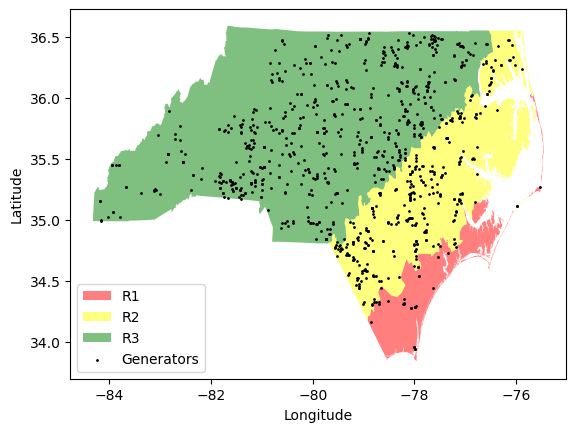

In [205]:
fig, ax = plt.subplots()

count=0
for geom in new_polyR1.geoms:    
    xs, ys = geom.exterior.xy    
    count=count+1
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none',label="R1")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')

count=0
for geom in new_polyR2.geoms:    
    count=count+1
    xs, ys = geom.exterior.xy    
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none',label="R2")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none')


xs, ys = new_polyR3.exterior.xy    
ax.fill(xs, ys, alpha=0.5, fc='green', ec='none',label="R3")


plt.scatter(df_AggregateGen["Longitude"],df_AggregateGen["Latitude"],color="black",s=1, label="Generators")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("RegionsByRisk.png")


### Write df on sql format

In [206]:
dfExistingCapacity_sql = pd.DataFrame(columns=["regions", "tech", "vintage", "exist_cap", "exist_cap_units", "exist_cap_notes"])
dfExistingCapacity_sql["regions"]=dfExistingCapacity["Region"]
dfExistingCapacity_sql["tech"]=dfExistingCapacity["PlantID"].str.split('_').str[1:3].str.join('_')


dfExistingCapacity_sql["vintage"]=dfExistingCapacity["Vintage"]
dfExistingCapacity_sql["exist_cap"]=dfExistingCapacity["NameplateCapacity(MW)"]/1000 #MW to GW
dfExistingCapacity_sql["exist_cap_units"]="GW"
dfExistingCapacity_sql["exist_cap_notes"]="EIA 860 Generator + Code 2 aggregate"

In [219]:
#Export unique tech name and description to facilitate the manual mapping
data1=dfExistingCapacity_sql["tech"].unique()
data2=[dfExistingCapacity[ dfExistingCapacity["PlantID"].str.split('_').str[1:3].str.join('_')==tech]["Technology"].iloc[0] for tech in dfExistingCapacity_sql["tech"].unique()]

dfExistingCapacity_sql["tech"]=dfExistingCapacity_sql["tech"]+"_Existing"
data1=data1+"_Existing"
data=zip(data1,data2)

ExistingCapacity_UniqueTechNamedf=pd.DataFrame(columns=["tech","description"],data=data)
ExistingCapacity_UniqueTechNamedf.to_excel(UserDataPath + "Temporary_ToHelpBuildDecks/TMP_ExistingCapacity_UniqueTechNameLv2.xlsx",index=False)

## LifetimeTech & LifetimeLoanTech

### Get Energy Capacity With Specific Retirement Dates

In [238]:
#Read File
df_Retirement = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='LifeTimeSpecific')

#On EIA 860 combined cycle tech are divided in CT and CA (steam part)
#We need to combine them as CC: combine cycle
df_Retirement.loc[df_Retirement["MoverCode"]=="CT","MoverCode"]="CC"
df_Retirement.loc[df_Retirement["MoverCode"]=="CA","MoverCode"]="CC"

for i in range(df_Retirement.shape[0]):
    Latitude=df_Retirement.iloc[i]["Latitude"]
    Longitude=df_Retirement.iloc[i]["Longitude"]

    if new_polyR1.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R1'

    elif new_polyR2.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R2'
    
    elif new_polyR3.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R3'

    else:
        print("Error")
        break
df_Retirement["tech"]=df_Retirement["SourceCode"]+"_"+df_Retirement["MoverCode"] + "_Existing"

In [239]:
#Aggregate the retirement data (df_AggregateRetirement)
df_AggregateRetirement = pd.DataFrame(columns=["PlantID","SourceCode", "MoverCode", "RetireYear", "NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)", "Region"])

for Region in ["R1","R2","R3"]:

    df_tmp1=df_Retirement[df_Retirement["Region"]==Region]

    SourceCode=df_tmp1["SourceCode"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["SourceCode"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["MoverCode"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["MoverCode"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]
            
            RetireYear=df_tmp3["RetireYear"]
            for RefRetireYear in RetireYear.unique():

                IdxsIn=df_tmp3["RetireYear"]==RefRetireYear
                if sum(IdxsIn)!=0:
                    #So far only considering data for non BA technology
                    if UniqueMC!="BA":
                        df_tmp4    = df_tmp3[IdxsIn]

                        NameplateCapacity=np.sum(df_tmp4["NameplateCapacity(MW)"])
                        NetSummerCapacity=np.sum(df_tmp4["NetSummerCapacity(MW)"])
                        NetWinterCapacity=np.sum(df_tmp4["NetWinterCapacity(MW)"])
                        
                        NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC + "_Existing"


                        Data=[[NewPlantID, UniqueSC, UniqueMC, RefRetireYear,
                        NameplateCapacity, NetSummerCapacity, NetWinterCapacity,Region]]

                        df_AggregateRetirement=pd.concat([df_AggregateRetirement,pd.DataFrame(Data,columns=df_AggregateRetirement.columns)],ignore_index=True)
                        

### Build a sql for the LifetimeTech & LifetimeLoanTech

In [240]:
#Read File
df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='LifeTimesLoanTechDefault')

dfLifetimeTech_sql = pd.DataFrame(columns=["Regions","tech", "life", "life_notes"])
dfLifetimeLoanTech_sql = pd.DataFrame(columns=["Regions","tech", "loan", "loan_notes"])


Regions=["R1"]*len(df)+["R2"]*len(df)+["R3"]*len(df)
tech=np.tile(df["tech"],3)
life=np.tile(df["life tech"],3)
loan=np.tile(df["loan"],3)
Observations=np.tile(df["Observations"],3)

dfLifetimeTech_sql["Regions"]=Regions
dfLifetimeTech_sql["tech"]=tech
dfLifetimeTech_sql["life"]=life
dfLifetimeTech_sql["life_notes"]=Observations

dfLifetimeLoanTech_sql["Regions"]=Regions
dfLifetimeLoanTech_sql["tech"]=tech
dfLifetimeLoanTech_sql["loan"]=loan
dfLifetimeLoanTech_sql["loan_notes"]=Observations

## ExistingCapacity Changes to Match Known Retirements

In [241]:
# Change the operation year and allocate capacity to match known retirements and LifetimeTech
# On temoa there is only one LifetimeTech value per technology. Since we grouped the technologies part of it 
# may retire at different times. We only know the expected retirements for a few generators (~60%) we need to make sure retirements happen at the right time
dfExistingCapacity_sql_adjusted = dfExistingCapacity_sql.copy()

for i in range(df_Retirement.shape[0]):
    #Retirement data
    OperatingYear=df_Retirement.iloc[i]["OperatingYear"]
    RetireYear=df_Retirement.iloc[i]["RetireYear"]

    Region=df_Retirement.iloc[i]["Region"]
    SourceCode=df_Retirement.iloc[i]["SourceCode"]
    MoverCode=df_Retirement.iloc[i]["MoverCode"]
    tech=df_Retirement.iloc[i]["tech"]
    NameplateCapacity=df_Retirement.iloc[i]["NameplateCapacity(MW)"]/1000 #MW to GW
    NetSummerCapacity=df_Retirement.iloc[i]["NetSummerCapacity(MW)"]/1000 #MW to GW
    NetWinterCapacity=df_Retirement.iloc[i]["NetWinterCapacity(MW)"]/1000 #MW to GW

    #Defined in the sql file is the same for all tehcnologies of the same type
    LifeOfTech=dfLifetimeTech_sql[(dfLifetimeTech_sql["tech"]==tech) * (dfLifetimeTech_sql["Regions"]==Region)]["life"].iloc[0]

    #Check for tech and regions that are the same
    IdxCandidate= (dfExistingCapacity_sql["regions"]==Region) * (dfExistingCapacity_sql["tech"]==tech)
    
    if sum(IdxCandidate)!=0:
        
        #Check for years that are the same of very close
        Targets=(dfExistingCapacity_sql[IdxCandidate]["vintage"]-OperatingYear).abs()
        EC_Av_Discount=np.sum(dfExistingCapacity_sql[IdxCandidate]["exist_cap"][Targets==0]) #Existing capacity available for discount
        
        if EC_Av_Discount>=NameplateCapacity: #a buffer of 0 years between retirements and existing capacity is allowed (change Targets==0 to Targets<=1 to allow for a 1 year buffer)            
            NewVintageLocation=RetireYear-LifeOfTech #Year that the resource should be placed to match retirements

            #add
            Data=[[Region,tech, NewVintageLocation, NameplateCapacity, "GW", "New add for retirement ballance"]]
            dfExistingCapacity_sql_adjusted=pd.concat([dfExistingCapacity_sql_adjusted,pd.DataFrame(Data,columns=dfExistingCapacity_sql.columns)],ignore_index=True) 

            #subtract
            Data=[[Region,tech, OperatingYear, -NameplateCapacity, "GW", "New add for retirement ballance"]]
            dfExistingCapacity_sql_adjusted=pd.concat([dfExistingCapacity_sql_adjusted,pd.DataFrame(Data,columns=dfExistingCapacity_sql.columns)],ignore_index=True)            

        else:
            print("Error- Inconsistency between retirements and existing capacity. Not enought capacity on the EIA 860 forms for the target retire")
            print("On Retirement Info: Tech (%s)  OperatingYear (%s)  NameplateCapacity (%s)"%(tech,OperatingYear,NameplateCapacity))
            break


In [242]:
dfExistingCapacity_sql_adjusted_tmp=dfExistingCapacity_sql_adjusted.groupby(["regions","tech","vintage"])["exist_cap"].sum().reset_index()
dfExistingCapacity_sql_adjusted_tmp["exist_cap_units"]="GW"
dfExistingCapacity_sql_adjusted_tmp["exist_cap_notes"]="EIA 860 Generator + Code 2 aggregate"

#Check for negative values
#pop error
if np.sum(dfExistingCapacity_sql_adjusted_tmp[dfExistingCapacity_sql_adjusted_tmp["exist_cap"]<0]["exist_cap"])<=-1/1000: #1MW of inconsistency:
    print("Error- Inconsistency between retirements and existing capacity. Negative values existing capacity")
else:
    dfExistingCapacity_sql_adjusted_tmp=dfExistingCapacity_sql_adjusted_tmp[dfExistingCapacity_sql_adjusted_tmp["exist_cap"]>0]
    dfExistingCapacity_sql_adjusted=dfExistingCapacity_sql_adjusted_tmp
    print("Known retirements properly allocated to existing capacity.")

#dfExistingCapacity_sql_adjusted: corrected ExistingCapacityValues

Known retirements properly allocated to existing capacity.


### Print Retirements

Text(0.5, 1.0, 'Time of Retirement of Existing Capacity <2023 \n 0.19 % of total exisitng capacity')

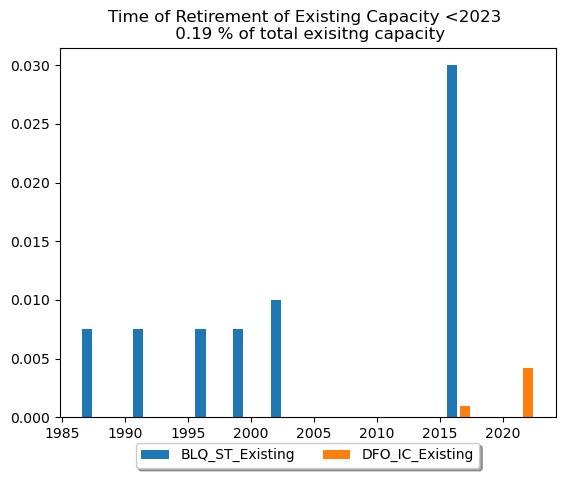

In [243]:
UniqueExistingTech=dfExistingCapacity_sql_adjusted["tech"].unique()

df=dfExistingCapacity_sql_adjusted.copy().reset_index(drop=True)
df["RetireYear"]=0

for i in range(len(df)):
    Life=dfLifetimeTech_sql[dfLifetimeTech_sql["tech"]==df.at[i,"tech"]].iloc[0]["life"]
    
    df.at[i,"RetireYear"]=int(Life + df.at[i,"vintage"])


MinRetirement=df["RetireYear"].min()
MaxRetirement=2023#df["RetireYear"].max()

YearsPlot=np.arange(MinRetirement,MaxRetirement,1)

Data=np.zeros((len(UniqueExistingTech),len(YearsPlot)))

for i in range(len(UniqueExistingTech)):
    for j in range(len(YearsPlot)):

        Data[i,j]=np.sum(df[(df["tech"]==UniqueExistingTech[i])*(df["RetireYear"]==YearsPlot[j])]["exist_cap"])

fig, ax = plt.subplots()

for i in range(Data.shape[0]):
  if np.sum (Data[i,:])!=0:
    ax.bar(YearsPlot, Data[i,:], label = UniqueExistingTech[i])
  
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.title("Time of Retirement of Existing Capacity <2023 \n %.2f %% of total exisitng capacity"%(np.sum(Data)/np.sum(df["exist_cap"])*100))


### Last Ajustment in Existing Capacity

In [244]:
#Capacity that is mathematically already retired (due to lifetime values) but not rerited according to EIA 860 are elimited from the model
#However, you can explicitly imput the retirement date of this generation (of any generation) on the user data (LifeTimeSpecific) excel file is you want to keep it.

dfExistingCapacity_sql_adjusted=df[df["RetireYear"]>=np.min(FutureYears)]
dfExistingCapacity_sql=dfExistingCapacity_sql_adjusted.drop(columns=["RetireYear"])

## Demand

### Get Population at Each Region

In [245]:
#For demand we get total energy demand of the sate from the IRPs
#and allocate the demand to R1, R2, R3 based on the population of each region
shapefile_Pop = gpd.read_file(CensusDataPath)
PointsPop=[Point(shapefile_Pop["LONGITUDE"][i],shapefile_Pop["LATITUDE"][i]) for i in range(len(shapefile_Pop))]
PopulationR1=0
PopulationR2=0
PopulationR3=0

ListCensusPop=[]
ListCensusOnR1,ListCensusOnR2,ListCensusOnR3=[],[],[]

for i in range(len(PointsPop)):
    point=PointsPop[i]
    ListCensusPop.append(shapefile_Pop["POPULATION"][i])
    if new_polyR1.contains(point):
        PopulationR1=PopulationR1+shapefile_Pop["POPULATION"][i]
        ListCensusOnR1.append(i)
        
    elif new_polyR2.contains(point):
        PopulationR2=PopulationR2+shapefile_Pop["POPULATION"][i]
        ListCensusOnR2.append(i)

    elif new_polyR3.contains(point):
        PopulationR3=PopulationR3+shapefile_Pop["POPULATION"][i]
        ListCensusOnR3.append(i)

### Read Demand From User and Regionalize

In [246]:
#Read from excel
NonRegionalizedDemand_df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='Demand')

#Get demand in each region
DemandR1=PopulationR1/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]
DemandR2=PopulationR2/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]
DemandR3=PopulationR3/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]

#Filter for the future years
DemandR1=DemandR1[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears)]
DemandR2=DemandR2[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears)]
DemandR3=DemandR3[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears)]


#Create sql dataframe
Demand_sql = pd.DataFrame(columns=["regions", "periods", "demand_comm", "demand", "demand_units", "demand_notes"])

Demand_sql["regions"]=["R1"]*len(FutureYears)+["R2"]*len(FutureYears)+["R3"]*len(FutureYears)
Demand_sql["periods"]=np.tile(FutureYears,3)
Demand_sql["demand"]=np.concatenate((DemandR1,DemandR2,DemandR3),axis=0)

Demand_sql["demand_units"]="PJ"
Demand_sql["demand_comm"]="ELCD" #Electricity demand
Demand_sql["demand_notes"]=NonRegionalizedDemand_df["Comments"][0]


## time (_of_day, _period_labels, _periods, _renewable, _season)

In [247]:
#time_of_day
time_of_day_sql=pd.DataFrame(columns=["t_day"])
time_of_day_sql["t_day"]=TimeOfDay

#time_period_labels
time_period_labels_sql=pd.DataFrame(columns=["t_period_labels","t_periods_labels_desc"])
time_period_labels_sql["t_period_labels"]=["e","f"]
time_period_labels_sql["t_periods_labels_desc"]=["existing vintages","future"]

#time_periods
time_periods_sql=pd.DataFrame(columns=["t_periods","flag"])
Exisist=Vintages[0:np.where(Vintages==dfExistingCapacity_sql["vintage"].min())[0][0]]
Exisist=Exisist[::-1]
Fut=FutureYears
Periods=np.concatenate((Exisist,Fut))

time_periods_sql["t_periods"]=Periods
time_periods_sql.loc[time_periods_sql["t_periods"]<=dfExistingCapacity_sql["vintage"].max(),"flag"]="e"
time_periods_sql.loc[time_periods_sql["t_periods"]>dfExistingCapacity_sql["vintage"].max(),"flag"]="f"

#time_renewable (Empty)
time_renewable_sql=pd.DataFrame(columns=["Field1"])

#time_season
time_of_day_sql=pd.DataFrame(columns=["t_season"])
time_of_day_sql["t_season"]=Seasons

## sector_labels, technology_labels

In [248]:
#sector_labels
sector_labels_sql=pd.DataFrame(columns=["sector"])
sector_labels_sql["sector"]=["supply","electric","electric_misc","transport","commercial", "residential","industrial"]

In [249]:
technology_labels_sql=pd.DataFrame(columns=["tech_labels","tech_labels_desc"])
technology_labels_sql["tech_labels"]=["r","p","pb","ps"]
technology_labels_sql["tech_labels_desc"]=["resource technology","production technology","baseload production technology","storage production technology"]

## technologies

In [250]:
#Read from excel
technologies_sql = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='technologies')
technologies_sql=technologies_sql.drop(columns=["Observations"])
technologies_sql["tech_category"]=""

# #verify content
if set(technologies_sql.columns)!=(set(["tech", "flag", "sector", "tech_desc", "tech_category"])):
    print("Error: There are heads in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
    sys.exit()

if set(technologies_sql["flag"].unique()).issubset(set(technology_labels_sql["tech_labels"]))!=True:
    print("Error: There are elements flag in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
    sys.exit()

if set(technologies_sql["sector"].unique()).issubset(set(sector_labels_sql["sector"]))!=True:
    print("Error: There are elements sector in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
    sys.exit()

### Get region and name of unique existing and future tech

In [251]:
UniqueExistingTech=dfExistingCapacity_sql.groupby(["regions","tech"]).size().reset_index().rename(columns={0:'Occurances'}) 
UniqueExistingTech=UniqueExistingTech.drop(columns=["Occurances"])

df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='NewTechRegions')

regions=[]
tech=[]
for i in range(len(df)):
    if df.iloc[i]["R1"]==1:
        regions.append("R1")
        tech.append(df.iloc[i]["tech"])

    if df.iloc[i]["R2"]==1:
        regions.append("R2")
        tech.append(df.iloc[i]["tech"])

    if df.iloc[i]["R3"]==1:
        regions.append("R3")
        tech.append(df.iloc[i]["tech"])

UniqueFutureTech = pd.DataFrame(list(zip(regions, tech)),columns=["regions","tech"])

### Adjust LifeTimeTech & Loan

In [252]:
UniqueEFTech = pd.concat([UniqueExistingTech,UniqueFutureTech])
KeepRows=[]

for tech,region in zip(dfLifetimeLoanTech_sql["tech"],dfLifetimeLoanTech_sql["Regions"]):

    if (region, tech) not in set(zip(UniqueEFTech["regions"], UniqueEFTech["tech"])):
        KeepRows.append(False)
    else:
        KeepRows.append(True)

#Only keep the rows that of values relevant to the model
dfLifetimeLoanTech_sql=dfLifetimeLoanTech_sql[KeepRows]
dfLifetimeTech_sql=dfLifetimeTech_sql[KeepRows]

## CostInvest

In [253]:
df = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='CostInvest')

CostInvest_sql = pd.DataFrame(columns=["regions","tech","vintage","cost_invest","cost_invest_units","cost_invest_notes"])

for region, tech in zip(UniqueFutureTech["regions"], UniqueFutureTech["tech"]):

    df_tmp=df[df["tech"]==tech]

    if np.sum(df_tmp["Stage"]==UserScenario)!=0:
        df_tmp=df_tmp[df_tmp["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp=df_tmp[df_tmp["Stage"]=="Single"]

    if len(df_tmp)==0:
        print("Error: There are no values for the technology "+tech+" in the CostInvest sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break

    for vintage in FutureYears[:-1]:

        cost_invest=df_tmp[vintage].iloc[0]
        cost_invest_units=df_tmp["cost_invest_units"].iloc[0]
        cost_invest_notes=df_tmp["cost_invest_notes"].iloc[0]
        Data=[[region, tech, vintage, cost_invest, cost_invest_units, cost_invest_notes]]

        CostInvest_sql=pd.concat([CostInvest_sql,pd.DataFrame(Data,columns=CostInvest_sql.columns)],ignore_index=True)      

## CostFixed and CostVariable

### Future Tech

In [254]:
#Cost only depends on the vintage> it does not change with the period

df_Fixed    = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='CostFixed')
df_Variable = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='CostVariable')

CostFixed_sql    = pd.DataFrame(columns=["regions","periods","tech","vintage","cost_fixed","cost_fixed_units","cost_fixed_notes"])
CostVariable_sql = pd.DataFrame(columns=["regions","periods","tech","vintage","cost_variable","cost_variable_units","cost_variable_notes"])


#Future Tech
for region, tech in zip(UniqueFutureTech["regions"], UniqueFutureTech["tech"]):

    df_tmp_CostFixed_sql    = df_Fixed[df_Fixed["tech"]==tech]
    df_tmp_CostVariable_sql = df_Variable[df_Variable["tech"]==tech]


    if np.sum(df_tmp_CostFixed_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]=="Single"]
        

    if np.sum(df_tmp_CostVariable_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]=="Single"]
    

    if len(df_tmp_CostFixed_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostFixed sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break
    if len(df_tmp_CostVariable_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostVariable sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break


    for i in range(len(FutureYears[:-1])):

        vintage=FutureYears[i]
        cost_fixed=df_tmp_CostFixed_sql[vintage].iloc[0]
        cost_variable=df_tmp_CostVariable_sql[vintage].iloc[0]

        cost_fixed_units    = df_tmp_CostFixed_sql   ["cost_fixed_units"].iloc[0]
        cost_variable_units = df_tmp_CostVariable_sql["cost_variable_units"].iloc[0]

        cost_fixed_notes    = df_tmp_CostFixed_sql   ["cost_fixed_notes"].iloc[0]
        cost_variable_notes = df_tmp_CostVariable_sql["cost_variable_notes"].iloc[0]

        for period in FutureYears[i:-1]:

            Data=[[region, period, tech, vintage, cost_fixed, cost_fixed_units, cost_fixed_notes]]
            CostFixed_sql=pd.concat([CostFixed_sql,pd.DataFrame(Data,columns=CostFixed_sql.columns)],ignore_index=True)  

            Data=[[region, period, tech, vintage, cost_variable, cost_variable_units, cost_variable_notes]]
            CostVariable_sql=pd.concat([CostVariable_sql,pd.DataFrame(Data,columns=CostVariable_sql.columns)],ignore_index=True)  

### Existing Tech

In [255]:
#Existing Tech
UniqueExistingTech=dfExistingCapacity_sql.groupby(["regions","tech","vintage"]).size().reset_index().rename(columns={0:'Occurances'}) 
UniqueExistingTech=UniqueExistingTech.drop(columns=["Occurances"])



for region, tech, vintage in zip(UniqueExistingTech["regions"], UniqueExistingTech["tech"],UniqueExistingTech["vintage"]):

    df_tmp_CostFixed_sql    = df_Fixed[df_Fixed["tech"]==tech]
    df_tmp_CostVariable_sql = df_Variable[df_Variable["tech"]==tech]


    if np.sum(df_tmp_CostFixed_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostFixed_sql=df_tmp_CostFixed_sql[df_tmp_CostFixed_sql["Stage"]=="Single"]
        

    if np.sum(df_tmp_CostVariable_sql["Stage"]==UserScenario)!=0:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]==UserScenario]

        #If you cant find UserScenario you assign "Single" as the scenario
    else:
        df_tmp_CostVariable_sql=df_tmp_CostVariable_sql[df_tmp_CostVariable_sql["Stage"]=="Single"]
    

    if len(df_tmp_CostFixed_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostFixed sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break
    if len(df_tmp_CostVariable_sql)==0:
        print("Error: There are no values for the technology "+tech+" in the CostVariable sheet")
        print("Look at the path: " + UserDataPath+"UserDataPart1.xlsx")
        break


    #For existing tech the cost is the costs of the earliest vintage year
    cost_fixed=df_tmp_CostFixed_sql.iloc[:,4].values[0]
    cost_variable=df_tmp_CostVariable_sql.iloc[:,4].values[0]
    
    cost_fixed_units    = df_tmp_CostFixed_sql   ["cost_fixed_units"].iloc[0]
    cost_variable_units = df_tmp_CostVariable_sql["cost_variable_units"].iloc[0]

    cost_fixed_notes    = df_tmp_CostFixed_sql   ["cost_fixed_notes"].iloc[0]
    cost_variable_notes = df_tmp_CostVariable_sql["cost_variable_notes"].iloc[0]

    for period in FutureYears[:-1]:

        Data=[[region, period, tech, vintage, cost_fixed, cost_fixed_units, cost_fixed_notes]]
        CostFixed_sql=pd.concat([CostFixed_sql,pd.DataFrame(Data,columns=CostFixed_sql.columns)],ignore_index=True)  

        Data=[[region, period, tech, vintage, cost_variable, cost_variable_units, cost_variable_notes]]
        CostVariable_sql=pd.concat([CostVariable_sql,pd.DataFrame(Data,columns=CostVariable_sql.columns)],ignore_index=True)  


### Filter for Consistency in Life Tech (Eliminate costs for tech tech "retired")

In [256]:
#Filter for year and lifetime
KeepRows=[]
for (region, period, tech, vintage) in zip(CostVariable_sql["regions"], CostVariable_sql["periods"], CostVariable_sql["tech"],CostVariable_sql["vintage"]):
    LifeOfTech=dfLifetimeTech_sql[(dfLifetimeTech_sql["tech"]==tech) * (dfLifetimeTech_sql["Regions"]==region)]["life"].iloc[0]

    if (vintage+LifeOfTech)<=period:
        KeepRows.append(False)

    else:
        KeepRows.append(True)

CostVariable_sql=CostVariable_sql[KeepRows]
CostFixed_sql=CostFixed_sql[KeepRows]

#Filter for zeros (transmission has default values of zero) If you run this line you will get an error
# CostVariable_sql=CostVariable_sql[CostVariable_sql["cost_variable"]>0] 
# CostFixed_sql=CostFixed_sql[CostFixed_sql["cost_fixed"]>0]

## Define Transmission/Distribution System Costs and configuration

### System Definition

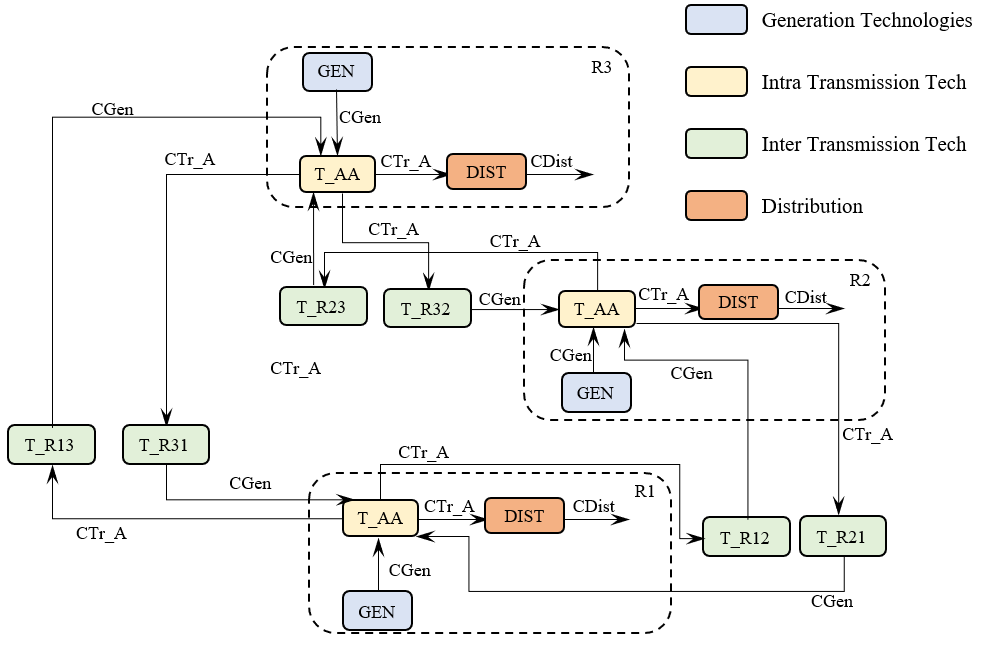

In [257]:
# For a system with three regions (R1-R2-R3) we consider the theoretical scenario where a single transmission system connects R1->R2 and R2->R3.
# As such the following connections must be defined:
# R1->R1 # R2->R2 # R3->R3
# R1->R2 # R2->R3

# On this theoretical framework we can use the current demand values of each region and the existing generation capacity and costs
# to calculate the size of each transmission system: This is done by running TEMOA with a single future period (2020-2022) 

# Additional data you need: 
# Total Transmission System Cost North Carolina
# Transmission system cost of interconnections ($/GW) R1>R2, R2>R3

# On temoa the transmission system costs R1<>R2 is divided by 2 to account for the fact that the transmission system is bidirectional
# As such we have two transmission lines R1->R2 and R2->R1. There is a constraint in the model to enforce that the two lines have the same capacity

#We represent the transmission in the same region by using an intermediate commodity. R1>R1, R2>R2, R3>R3

#------------------------------------------------------------------------------------------- Flow Diagram for the Transmission System ----------------------------------------------------------------------------------
#
Image("TransmissionConfiguration.png")

### Identify the Load Center in Each Region

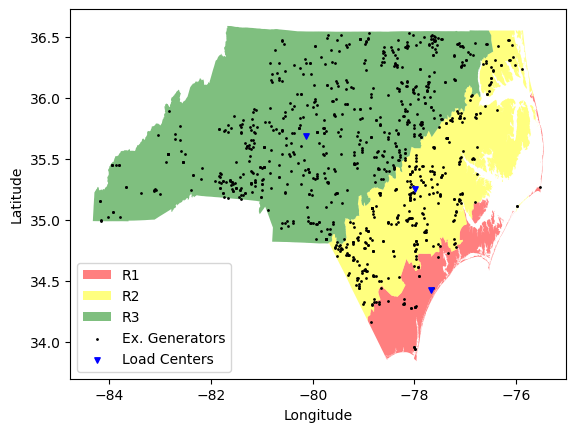

In [258]:
#Load center is defined based on the population of each county on the region (it is the same of the centroid of the population)
#shapefile_Pop and PointsPop is available at Demand chapter
PointsPopLongLat=np.array([[shapefile_Pop["LONGITUDE"][i],shapefile_Pop["LATITUDE"][i]] for i in range(len(shapefile_Pop))])
ListCensusPop=np.array(ListCensusPop)

CentroidLoadR1=np.sum(np.reshape(ListCensusPop[ListCensusOnR1]/np.sum(ListCensusPop[ListCensusOnR1]),(len(ListCensusOnR1),1))*PointsPopLongLat[ListCensusOnR1],axis=0)#Long Lat
CentroidLoadR2=np.sum(np.reshape(ListCensusPop[ListCensusOnR2]/np.sum(ListCensusPop[ListCensusOnR2]),(len(ListCensusOnR2),1))*PointsPopLongLat[ListCensusOnR2],axis=0)#Long Lat
CentroidLoadR3=np.sum(np.reshape(ListCensusPop[ListCensusOnR3]/np.sum(ListCensusPop[ListCensusOnR3]),(len(ListCensusOnR3),1))*PointsPopLongLat[ListCensusOnR3],axis=0)#Long Lat

#Computing distance between centroids
DistanceR1R2=haversine((CentroidLoadR1[1], CentroidLoadR1[0]), (CentroidLoadR2[1], CentroidLoadR2[0]), unit='mi') #Haversine works on lat long
DistanceR2R3=haversine((CentroidLoadR2[1], CentroidLoadR2[0]), (CentroidLoadR3[1], CentroidLoadR3[0]), unit='mi') #Haversine works on lat long


fig, ax = plt.subplots()

count=0
for geom in new_polyR1.geoms:    
    xs, ys = geom.exterior.xy    
    count=count+1
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none',label="R1")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')

count=0
for geom in new_polyR2.geoms:    
    count=count+1
    xs, ys = geom.exterior.xy    
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none',label="R2")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none')


xs, ys = new_polyR3.exterior.xy    
ax.fill(xs, ys, alpha=0.5, fc='green', ec='none',label="R3")

LongLatCentroids=np.concatenate([np.array([CentroidLoadR1]),np.array([CentroidLoadR2]),np.array([CentroidLoadR3])],axis=0)

plt.scatter(df_AggregateGen["Longitude"],df_AggregateGen["Latitude"],color="black",s=1, label="Ex. Generators")
plt.scatter(LongLatCentroids[:,0],LongLatCentroids[:,1],color="blue",s=15,marker="v", label="Load Centers")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("Load Centroids.png",dpi=600)



In [ ]:
#CentroidLoadR1: close to Wilmington
#CentroidLoadR2: Goldsboro
#CentroidLoadR3: Lexington

### Costs (Investment Fixed and Variable)

In [259]:
#Read from excel
#The transmission cost between regions is defined based on ReEDS data and DUKE data (Miles & KV of transmission line)
#Tp compute it we use the diststance between centroids and the average transmission cost per mile per MW
TransmissionExcel = pd.read_excel(UserDataPath+"UserDataPart1.xlsx", sheet_name ='TransmissionCalculations')
AverageTranmsissionCost=TransmissionExcel.iloc[8,1] #[$/(MW*Mile)]
InvestmentCost_TransmissionR1R2=DistanceR1R2*AverageTranmsissionCost/1000 #[M$/GW]=[$/kW]
InvestmentCost_TransmissionR2R3=DistanceR2R3*AverageTranmsissionCost/1000 #[M$/GW]
InvestmentCost_TransmissionR1R3=InvestmentCost_TransmissionR1R2+InvestmentCost_TransmissionR2R3 #Installing capacity in this line to connect R1 and R3 is the same as installing capacity in R1R2 and R2R3. We use this
#representation to facilitate the model formulation on temoa

#Regional Investment Cost
InvestmentCost_TransmissionR1R1=TransmissionExcel.iloc[9,1] #[M$/GW]=[$/kW]
InvestmentCost_TransmissionR2R2=TransmissionExcel.iloc[9,1] #[M$/GW]=[$/kW]
InvestmentCost_TransmissionR3R3=TransmissionExcel.iloc[9,1] #[M$/GW]=[$/kW]


In [260]:
#Change CostInvest_sql (Regional transmission)
CostInvest_sql.loc[(CostInvest_sql["tech"]=="Transmission_Regional") & (CostInvest_sql["regions"]=="R1"),"cost_invest"]=InvestmentCost_TransmissionR1R1
CostInvest_sql.loc[(CostInvest_sql["tech"]=="Transmission_Regional") & (CostInvest_sql["regions"]=="R2"),"cost_invest"]=InvestmentCost_TransmissionR2R2
CostInvest_sql.loc[(CostInvest_sql["tech"]=="Transmission_Regional") & (CostInvest_sql["regions"]=="R3"),"cost_invest"]=InvestmentCost_TransmissionR3R3


#CostInvest_sql (Interregional transmission)
#Delete Transmission_Interregional on CostInvest_sql and rebuild properly on TEMOA notation
CostInvest_sql=CostInvest_sql[CostInvest_sql["tech"]!="Transmission_Interregional"]

Data=[]
for vintage in FutureYears[:-1]:
    Data.append(["R1-R2", "Transmission_Interregional", vintage, InvestmentCost_TransmissionR1R2, "$/kW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R2-R1", "Transmission_Interregional", vintage, InvestmentCost_TransmissionR1R2, "$/kW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R2-R3", "Transmission_Interregional", vintage, InvestmentCost_TransmissionR2R3, "$/kW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R3-R2", "Transmission_Interregional", vintage, InvestmentCost_TransmissionR2R3, "$/kW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R1-R3", "Transmission_Interregional", vintage, InvestmentCost_TransmissionR1R3, "$/kW", "Modified Automatically from the Code (Values on the right are Default Value)"])
    Data.append(["R3-R1", "Transmission_Interregional", vintage, InvestmentCost_TransmissionR1R3, "$/kW", "Modified Automatically from the Code (Values on the right are Default Value)"])

CostInvest_sql=pd.concat([CostInvest_sql,pd.DataFrame(Data,columns=CostInvest_sql.columns)],ignore_index=True)      

#CostVariable_sql (Interregional transmission)
#Delete Transmission_Interregional on CostVariable_sql and rebuild properly on TEMOA notation
CostVariable_sql=CostVariable_sql[CostVariable_sql["tech"]!="Transmission_Interregional"]
VariableCost_InterTransmission=0
Data=[]
for period in list(FutureYears[:-1]):
    for vintage in list([Vintages[0]])+list(FutureYears[:-1]):
        Data.append(["R1-R2",period, "Transmission_Interregional", vintage, VariableCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R1",period, "Transmission_Interregional", vintage, VariableCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R3",period, "Transmission_Interregional", vintage, VariableCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R2",period, "Transmission_Interregional", vintage, VariableCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R1-R3",period, "Transmission_Interregional", vintage, VariableCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R1",period, "Transmission_Interregional", vintage, VariableCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])

CostVariable_sql=pd.concat([CostVariable_sql,pd.DataFrame(Data,columns=CostVariable_sql.columns)],ignore_index=True)      

#CostFixed_sql (Interregional transmission)
#Delete Transmission_Interregional on CostVariable_sql and rebuild properly on TEMOA notation
CostFixed_sql=CostFixed_sql[CostFixed_sql["tech"]!="Transmission_Interregional"]
FixedCost_InterTransmission=0
Data=[]
for period in list(FutureYears[:-1]):
    for vintage in list([Vintages[0]])+list(FutureYears[:-1]):
        Data.append(["R1-R2",period, "Transmission_Interregional", vintage, FixedCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R1",period, "Transmission_Interregional", vintage, FixedCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R2-R3",period, "Transmission_Interregional", vintage, FixedCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R2",period, "Transmission_Interregional", vintage, FixedCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R1-R3",period, "Transmission_Interregional", vintage, FixedCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])
        Data.append(["R3-R1",period, "Transmission_Interregional", vintage, FixedCost_InterTransmission, "$/kW-yr", "Modified Automatically from the Code (Values on the right are Default Value)"])

CostFixed_sql=pd.concat([CostFixed_sql,pd.DataFrame(Data,columns=CostFixed_sql.columns)],ignore_index=True)


### Set Lifetech for Interregional Transmission

In [261]:
#For interregional transmission we need to properly define the regions using TEMOA "dash" notation
ExcelData=dfLifetimeTech_sql[(dfLifetimeTech_sql["tech"]=="Transmission_Interregional") & (dfLifetimeTech_sql["Regions"]=="R3")]
life=ExcelData["life"].values[0]
life_notes=ExcelData["life_notes"].values[0]

dfLifetimeTech_sql=dfLifetimeTech_sql[dfLifetimeTech_sql["tech"]!="Transmission_Interregional"]
Data=[]
Data.append(["R1-R2", "Transmission_Interregional", life, life_notes])
Data.append(["R2-R1", "Transmission_Interregional", life, life_notes])
Data.append(["R2-R3", "Transmission_Interregional", life, life_notes])
Data.append(["R3-R2", "Transmission_Interregional", life, life_notes])
Data.append(["R1-R3", "Transmission_Interregional", life, life_notes])
Data.append(["R3-R1", "Transmission_Interregional", life, life_notes])

dfLifetimeTech_sql=pd.concat([dfLifetimeTech_sql,pd.DataFrame(Data,columns=dfLifetimeTech_sql.columns)],ignore_index=True)

In [262]:
#Filter for year and lifetime
KeepRows=[]
for (region, period, tech, vintage) in zip(CostVariable_sql["regions"], CostVariable_sql["periods"], CostVariable_sql["tech"],CostVariable_sql["vintage"]):
    LifeOfTech=dfLifetimeTech_sql[(dfLifetimeTech_sql["tech"]==tech) * (dfLifetimeTech_sql["Regions"]==region)]["life"].iloc[0]

    if (vintage+LifeOfTech)<=period:
        KeepRows.append(False)

    else:
        KeepRows.append(True)

CostVariable_sql=CostVariable_sql[KeepRows]
CostFixed_sql=CostFixed_sql[KeepRows]


### Existing Capacity

In [263]:
#All existing transmission capacity is assumed to be in place in the earlies vintage year (all capacity on 2022)

#TEMOA has a constrain to enforce CapacityR1R2=CapacityR2R1,...
#Transmission_Interregional
ExistingCap_TransmissionR1R2=0 #[GW]
ExistingCap_TransmissionR2R3=0 #[GW]
ExistingCap_TransmissionR1R3=0 #[GW]

#Transmission_Regional
ExistingCap_TransmissionR1R1=0 #[GW]
ExistingCap_TransmissionR2R2=0 #[GW]
ExistingCap_TransmissionR3R3=0 #[GW]

#Need to define
Data=[]
Data.append(["R1-R2", "Transmission_Interregional", Vintages[0], ExistingCap_TransmissionR1R2,	"GW",	"From Database Code"])
Data.append(["R2-R1", "Transmission_Interregional", Vintages[0], ExistingCap_TransmissionR1R2,	"GW",	"From Database Code"])

Data.append(["R1-R3", "Transmission_Interregional", Vintages[0], ExistingCap_TransmissionR2R3,	"GW",	"From Database Code"])
Data.append(["R3-R1", "Transmission_Interregional", Vintages[0], ExistingCap_TransmissionR2R3,	"GW",	"From Database Code"])

Data.append(["R2-R3", "Transmission_Interregional", Vintages[0], ExistingCap_TransmissionR1R3,	"GW",	"From Database Code"])
Data.append(["R3-R2", "Transmission_Interregional", Vintages[0], ExistingCap_TransmissionR1R3,	"GW",	"From Database Code"])

Data.append(["R1", "Transmission_Regional", Vintages[0], ExistingCap_TransmissionR1R1,	"GW",	"From Database Code"])
Data.append(["R2", "Transmission_Regional", Vintages[0], ExistingCap_TransmissionR2R2,	"GW",	"From Database Code"])
Data.append(["R3", "Transmission_Regional", Vintages[0], ExistingCap_TransmissionR3R3,	"GW",	"From Database Code"])

dfExistingCapacity_sql=pd.concat([dfExistingCapacity_sql,pd.DataFrame(Data,columns=dfExistingCapacity_sql.columns)],ignore_index=True)


## tech_exchange

In [264]:
tech_exchange_sql=pd.DataFrame([["Transmission_Interregional", "Transmission Interregions eg. R1>R2"]],columns=["tech","notes"])

# Code to Convert Excel Table to Sql data Part 2

## commodity_labels

In [265]:
#Read from excel
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='commodity_labels')
commodity_labels_sql=pd.DataFrame(ExcelDataP2.values,columns=["comm_labels","comm_labels_desc"])

## commodities

In [266]:
#Read from excel
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='commodities')
commodities_sql=pd.DataFrame(ExcelDataP2.values,columns=["comm_name","flag","comm_desc"])

## Efficiency

### Assign Efficiencies from Excel user data

In [267]:
#Construct the df for all valid combinations
#You can get all valid combinations for the future tech using CostInvest_sql
DummyString=np.array(['']*CostInvest_sql.shape[0])
DummyNumb=np.ones((CostInvest_sql.shape[0]))*-1
DataFuture=np.stack((CostInvest_sql["regions"].values,DummyString,CostInvest_sql["tech"].values,CostInvest_sql["vintage"].values,DummyString,DummyNumb,DummyString),axis=1)

#You can get all valid combinations for exising tech using dfExistingCapacity_sql
DummyString=np.array(['']*dfExistingCapacity_sql.shape[0])
DummyNumb=np.ones((dfExistingCapacity_sql.shape[0]))*-1
DataPast=np.stack((dfExistingCapacity_sql["regions"].values,DummyString,dfExistingCapacity_sql["tech"].values,dfExistingCapacity_sql["vintage"].values,DummyString,DummyNumb,DummyString),axis=1)


Efficiency_sql=pd.DataFrame(np.concatenate((DataFuture,DataPast),axis=0),columns=["regions","input_comm","tech","vintage","output_comm","efficiency","eff_notes"]) #Skelleton for the efficiency table

#Transfer the data from the excel file to the dataframe
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='Efficiency')
ExcelDataP2=ExcelDataP2[(ExcelDataP2["Stage"]=="single") + (ExcelDataP2["Stage"]==UserScenario)]

#Transfer Input and output commodities
for tech, imput_comm, output_comm in zip(ExcelDataP2["tech"],ExcelDataP2["input_comm"],ExcelDataP2["output_comm"]):
    Efficiency_sql.loc[Efficiency_sql["tech"]==tech,"input_comm"]=imput_comm
    Efficiency_sql.loc[Efficiency_sql["tech"]==tech,"output_comm"]=output_comm

for index, ExcelRowEffData in ExcelDataP2.iterrows():
    region=ExcelRowEffData["Region"]
    tech=ExcelRowEffData["tech"]
    eff_note=ExcelRowEffData["eff_notes"]

    if region=="single":
        Tech_vitages=Efficiency_sql.loc[(Efficiency_sql["tech"]==tech),"vintage"].values
        LastYearInEfficiencyTable=ExcelDataP2.columns[6]
        Tech_vitages[Tech_vitages<LastYearInEfficiencyTable]=LastYearInEfficiencyTable
        
        efficiency=[ExcelRowEffData[v] for v in Tech_vitages]
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech),"efficiency"]=efficiency
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech),"eff_notes"]=eff_note

    if region!="single":
        Tech_vitages=Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==region),"vintage"].values
        LastYearInEfficiencyTable=ExcelDataP2.columns[6]
        Tech_vitages[Tech_vitages<LastYearInEfficiencyTable]=LastYearInEfficiencyTable

        efficiency=[ExcelRowEffData[v] for v in Tech_vitages]
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==region) ,"efficiency"]=efficiency
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==region) ,"eff_notes"]=eff_note

    if tech=="Transmission_Interregional": #(Exception on Interregional Transmission) Same in both directions
        InvertRegion=region.split("-")[1]+"-"+region.split("-")[0]
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==InvertRegion) ,"efficiency"]=efficiency
        Efficiency_sql.loc[(Efficiency_sql["tech"]==tech) * (Efficiency_sql["regions"]==InvertRegion) ,"eff_notes"]=eff_note

#Verify that all the data is filled
if np.sum(Efficiency_sql["efficiency"]==-1)>0:
    print("ERROR: There are some efficiency values that are not filled")
    print(Efficiency_sql.loc[Efficiency_sql["efficiency"]==-1,:])
    sys.exit()

### Assign Efficiencies for existing tech using EIA 923 BTUs to GWh

In [307]:
#Have to enter the value by hand on the efficiency table
EIA923_df = pd.read_excel(EIA_923_Path,sheet_name ='Page 1 Generation and Fuel Data',skiprows=5)
EIA923_State=EIA923_df["Plant State"]
EIA923_df=EIA923_df[EIA923_State==State]

EIA923_df=EIA923_df[(EIA923_df["Net Generation\n(Megawatthours)"]>0)*(EIA923_df["Elec Fuel Consumption\nMMBtu"]>0)] #If no fuel was consumed you cannot calculate the efficiency

#On EIA 860 combined cycle tech are divided in CT and CA (steam part)
#We need to combine them as CC: combine cycle
EIA923_df.loc[EIA923_df["Reported\nPrime Mover"]=="CT","Reported\nPrime Mover"]="CC"
EIA923_df.loc[EIA923_df["Reported\nPrime Mover"]=="CA","Reported\nPrime Mover"]="CC"


EIA923_Mover=EIA923_df["Reported\nPrime Mover"]
EIA923_FuelType=EIA923_df["Reported\nFuel Type Code"]
EIA923_FuelConsuption=EIA923_df["Elec Fuel Consumption\nMMBtu"]
EIA923_EnergyGen=EIA923_df["Net Generation\n(Megawatthours)"]

UniqueMoverFuel = EIA923_df[["Reported\nFuel Type Code","Reported\nPrime Mover"]].drop_duplicates()

UniqueMoverFuel["MMBtu"]=0
UniqueMoverFuel["MWh"]=0
for Mover, Fuel in zip(UniqueMoverFuel.iloc[:,1],UniqueMoverFuel.iloc[:,0]):
    Idx=(UniqueMoverFuel["Reported\nPrime Mover"]==Mover) * (UniqueMoverFuel["Reported\nFuel Type Code"]==Fuel)

    UniqueMoverFuel.loc[Idx,"MMBtu"]=np.sum(EIA923_FuelConsuption[(EIA923_Mover==Mover) * (EIA923_FuelType==Fuel)])
    UniqueMoverFuel.loc[Idx,"MWh"]=np.sum(EIA923_EnergyGen[(EIA923_Mover==Mover) * (EIA923_FuelType==Fuel)])

UniqueMoverFuel["MWh/MMBtu"]=UniqueMoverFuel["MWh"]/UniqueMoverFuel["MMBtu"]
UniqueMoverFuel["MMBtu/MWh"]=UniqueMoverFuel["MMBtu"]/UniqueMoverFuel["MWh"]

In [308]:
UniqueMoverFuel.sort_values(['Reported\nFuel Type Code','Reported\nPrime Mover'], ascending=(True,True))

,Reported\nFuel Type Code,Reported\nPrime Mover,MMBtu,MWh,MWh/MMBtu,MMBtu/MWh
13834,AB,ST,72822,3.560000e+03,0.048886,20.455618
2203,BIT,ST,211992050,2.040464e+07,0.096252,10.389405
5301,BLQ,ST,5269578,9.924691e+05,0.188339,5.309564
933,DFO,CC,165286,1.624657e+04,0.098294,10.173594
935,DFO,GT,1283119,1.105445e+05,0.086153,11.607259
2249,DFO,IC,74515,6.304759e+03,0.084611,11.818850
2204,DFO,ST,610550,6.196798e+04,0.101495,9.852669
9863,LFG,FC,444152,5.477300e+04,0.123320,8.108959
6981,LFG,GT,1546018,9.531600e+04,0.061653,16.219921
7494,LFG,IC,3165782,2.988555e+05,0.094402,10.593018


In [312]:
#mean given all biomass fuels
BioFuel=["AB","BLQ","OBG","WDS"]
BTU=0
MWh=0
for Fuel in BioFuel:
    Idx=UniqueMoverFuel["Reported\nFuel Type Code"]==Fuel
    BTU=BTU+np.sum(UniqueMoverFuel.loc[Idx,"MMBtu"])
    MWh=MWh+np.sum(UniqueMoverFuel.loc[Idx,"MWh"])

print("Average Biomass Efficiency MMBTU/MWh: %.4f" % (BTU/MWh))

#Mean of Tech Specific:
Coal =["BIT"]
NG   =["NG"]
Petroleum=["DFO","KER", "RFO"]

RefFuel=NG
BTU=0
MWh=0
for Fuel in RefFuel:
    Idx=UniqueMoverFuel["Reported\nFuel Type Code"]==Fuel
    BTU=BTU+np.sum(UniqueMoverFuel.loc[Idx,"MMBtu"])
    MWh=MWh+np.sum(UniqueMoverFuel.loc[Idx,"MWh"])

print("\n\nAverage Tech Specific Efficiency MMBTU/MWh: %.4f\nTech Specific Total MMBTUs: %.2f" % (BTU/MWh,BTU))

Average Biomass Efficiency MMBTU/MWh: 7.2141


Average Tech Specific Efficiency MMBTU/MWh: 8.6686
Tech Specific Total MMBTUs: 375669277.00


## EmissionActivity

In [271]:
#Get the technologies we need to model efficiency from EmissionActivity on the excel file
#An get the sql structure from Efficiency_sql
ExcelDataP2 = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='EmissionActivity')
Data=[]


IdxIn=np.zeros(len(Efficiency_sql["tech"]),dtype=bool)
for i in range(len(ExcelDataP2["tech"])):
    IdxIn=IdxIn+(Efficiency_sql["tech"]==ExcelDataP2["tech"][i])

df_EfficiencyForEmission=Efficiency_sql[IdxIn]
df_EfficiencyForEmission.reset_index(inplace=True)

regions=df_EfficiencyForEmission["regions"]
input_comm=df_EfficiencyForEmission["input_comm"]
tech=df_EfficiencyForEmission["tech"]
vintage=df_EfficiencyForEmission["vintage"]
output_comm=df_EfficiencyForEmission["output_comm"]
efficiency=df_EfficiencyForEmission["efficiency"]

EmissionActivity_sql = pd.DataFrame({"regions":regions,
                                    "emis_comm":"",
                                    "input_comm":input_comm,
                                    "tech":tech,
                                    "vintage":vintage,
                                    "output_comm":output_comm,
                                    "emis_act":efficiency,
                                    "emis_act_units":"",
                                    "emis_act_notes":""})


for i in range(len(ExcelDataP2["tech"])):
    tech=ExcelDataP2["tech"][i]
    MMBtus2Lbs=ExcelDataP2["emission_act"][i]
    units=ExcelDataP2["units"][i]
    emission_comm=ExcelDataP2["emission_comm"][i]
    IdxIn=EmissionActivity_sql["tech"]==tech

    EmissionActivity_sql.loc[IdxIn,"emis_act"]=MMBtus2Lbs*1/EmissionActivity_sql.loc[IdxIn,"emis_act"]
    EmissionActivity_sql.loc[IdxIn,"emis_act_units"]="lbs/MWh"
    EmissionActivity_sql.loc[IdxIn,"emis_comm"]=emission_comm


## DemandSpecificDistribution

In [272]:
# Data from EIA-930 form (https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48)
# Get hourly demand data from EIA froms to know how the demand changes for each season an hour of the day
EIA_930_Paths = glob.glob(EIA_930_BalancePath + "\*.csv")

EIA_Data=pd.DataFrame(columns=["Year","Season","Hour", "Demand (MW)"])
for FilePath in EIA_930_Paths:
    df = pd.read_csv(FilePath,usecols = ["Balancing Authority",'Data Date',"Hour Number",'Demand (MW)'],low_memory=False)

    BAsIn=df["Balancing Authority"]==MajorBAs[0] # Initialize the boolean array to select the BAs
    for BA in MajorBAs:
        BAsIn=(df["Balancing Authority"]==BA) + BAsIn
    df=df[BAsIn]

    FileData=pd.DataFrame(columns=["Year","Season","Hour", "Demand (MW)"])
    FileData["Demand (MW)"]=df["Demand (MW)"].str.replace(',', '').astype(float)
    FileData["Year"]=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.year
    FileData["Hour"]=df["Hour Number"]

    Month=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.month
    SeasonDf=[]
    for month in Month:
        for j in range(len(Seasons)):
            if month in SeasonsMonthRange[j]:
                SeasonDf.append(Seasons[j])
                break
    FileData["Season"]=SeasonDf

    EIA_Data = pd.concat([EIA_Data,FileData], ignore_index = True)

    EIA_Data=EIA_Data[EIA_Data["Hour"]!=25] #Remove the 25th hour. On the EIA some days have 25 hours. I don't know why

In [273]:
Demand_Season_Hour_agg=pd.DataFrame(columns=["Year","Season","Hour", "Demand (MW)"])

for Season in Seasons:
    for Hour in EIA_Data["Hour"].unique():
        for Year in EIA_Data["Year"].unique():
            IdxIn=(EIA_Data["Season"]==Season)*(EIA_Data["Hour"]==Hour)*(EIA_Data["Year"]==Year)
            df=EIA_Data[IdxIn]
            Demand=df["Demand (MW)"].sum()
            Demand_Season_Hour_agg=pd.concat([Demand_Season_Hour_agg,pd.DataFrame([{"Year":Year,"Season":Season,"Hour":Hour,"Demand (MW)":Demand}])], ignore_index=True)

#Make demand as a percentage of the total demand on the year
for Year in Demand_Season_Hour_agg["Year"].unique():
    IdxIn=Demand_Season_Hour_agg["Year"]==Year
    Demand_Season_Hour_agg.loc[IdxIn,"Demand (MW)"]=Demand_Season_Hour_agg.loc[IdxIn,"Demand (MW)"]/Demand_Season_Hour_agg.loc[IdxIn,"Demand (MW)"].sum()

Demand_Season_Hour_agg=Demand_Season_Hour_agg.rename(columns={"Demand (MW)": "RatioOfYearDemand"})

#Get the average Trend
GeneralDemandDistribuion=pd.DataFrame(columns=["Season","Hour", "RatioOfDemand"])

for Season in Seasons:
    for Hour in Demand_Season_Hour_agg["Hour"].unique():
        IdxIn=(Demand_Season_Hour_agg["Season"]==Season)*(Demand_Season_Hour_agg["Hour"]==Hour)
        df=Demand_Season_Hour_agg[IdxIn]
        RatioOfDemand=df["RatioOfYearDemand"].mean()#Mean of all years
        GeneralDemandDistribuion=pd.concat([GeneralDemandDistribuion,pd.DataFrame([{"Season":Season,"Hour":Hour,"RatioOfDemand":RatioOfDemand}])], ignore_index=True)

### Plot Demand Specific Distribution

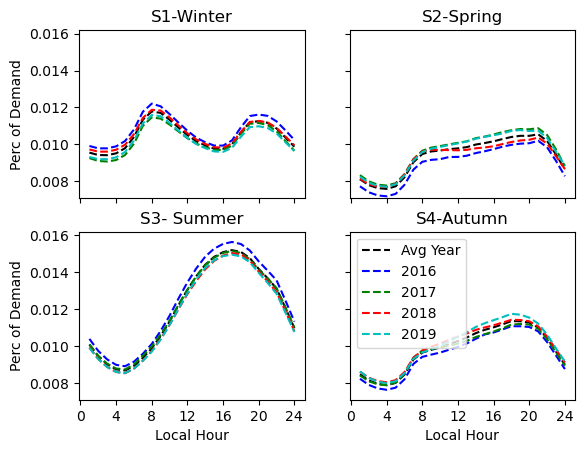

In [274]:
fig, axs = plt.subplots(2, 2)
G_S1Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S1"]
G_S2Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S2"]
G_S3Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S3"]
G_S4Data=GeneralDemandDistribuion[GeneralDemandDistribuion["Season"]=="S4"]
x=G_S2Data["Hour"].unique()

MinY=-0.0005+min(G_S1Data["RatioOfDemand"].min(),G_S2Data["RatioOfDemand"].min(),G_S3Data["RatioOfDemand"].min(),G_S4Data["RatioOfDemand"].min())
MaxY=0.001+max(G_S1Data["RatioOfDemand"].max(),G_S2Data["RatioOfDemand"].max(),G_S3Data["RatioOfDemand"].max(),G_S4Data["RatioOfDemand"].max())

axs[0, 0].set_title('S1-Winter')
axs[0, 1].set_title('S2-Spring')
axs[1, 0].set_title('S3- Summer')
axs[1, 1].set_title('S4-Autumn')

axs[0, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[0, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))

axs[0, 0].plot(x, G_S1Data["RatioOfDemand"],"k--")
axs[0, 1].plot(x, G_S2Data["RatioOfDemand"],"k--")
axs[1, 0].plot(x, G_S3Data["RatioOfDemand"],"k--")
axs[1, 1].plot(x, G_S4Data["RatioOfDemand"],"k--",label="Avg Year")

Colors=list(mcolors.BASE_COLORS.keys())
for i in range(len(Demand_Season_Hour_agg["Year"].unique())):
    year=Demand_Season_Hour_agg["Year"].unique()[i]
    G_S1Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S1")*(Demand_Season_Hour_agg["Year"]==year)]
    G_S2Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S2")*(Demand_Season_Hour_agg["Year"]==year)]
    G_S3Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S3")*(Demand_Season_Hour_agg["Year"]==year)]
    G_S4Data=Demand_Season_Hour_agg[(Demand_Season_Hour_agg["Season"]=="S4")*(Demand_Season_Hour_agg["Year"]==year)]

    axs[0, 0].plot(x, G_S1Data["RatioOfYearDemand"],Colors[i]+"--")
    axs[0, 1].plot(x, G_S2Data["RatioOfYearDemand"],Colors[i]+"--")
    axs[1, 0].plot(x, G_S3Data["RatioOfYearDemand"],Colors[i]+"--")
    axs[1, 1].plot(x, G_S4Data["RatioOfYearDemand"],Colors[i]+"--",label=year)

axs[0, 0].set_ylim(MinY, MaxY)
axs[0, 1].set_ylim(MinY, MaxY)
axs[1, 0].set_ylim(MinY, MaxY)
axs[1, 1].set_ylim(MinY, MaxY)

for ax in axs.flat:
    ax.set(xlabel="Local Hour", ylabel='Perc of Demand')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend()


### Write df on sql format

In [275]:
dds_notes="From EIA-930 Forms"

Data=[]
for region in Regions:
    for hour in range(len(TimeOfDay)):
        for season in Seasons:
            dds=GeneralDemandDistribuion[(GeneralDemandDistribuion["Season"]==season)*(GeneralDemandDistribuion["Hour"]==(hour+1))]["RatioOfDemand"].values[0]
            Data.append([region, season, TimeOfDay[hour],dds,dds_notes])
        
Deman_SpecificDistribution_sql=pd.DataFrame(Data, columns=["regions","season_name","time_of_day_name", "dds","dds_notes"])

## CapacityFactorProcess

### Estimate CF based on EIA 930

In [276]:
# Estimate CF based on EIA 930
TechEIA_SummaryFile=["Petroleum","Pumped storage","Other biomass","Solar"] #technology name on EIA summary file
Tech2EIA_930= {"Coal_EIA930":           "Net Generation (MW) from Coal",
                "NG_EIA930":             "Net Generation (MW) from Natural Gas",
                "Nuclear_EIA930":        "Net Generation (MW) from Nuclear",
                "Petroleum_EIA930":      "Net Generation (MW) from All Petroleum Products",
                "WATER_EIA930":          "Net Generation (MW) from Hydropower and Pumped Storage",
                "WIND_EIA930":           "Net Generation (MW) from Wind",
                "SOL_EIA930":            "Net Generation (MW) from Solar (Adjusted)"}

def EIA930_CFs(Tech, AvgY_CF):
    EIA930_Column=Tech2EIA_930[Tech]
    EIA_930_Paths = glob.glob(EIA_930_CFPath + "\*.csv")

    EIA_Data=pd.DataFrame(columns=["Year","Season","Hour", "Generation (MW)"])
    for FilePath in EIA_930_Paths:
        df = pd.read_csv(FilePath,usecols = ["Balancing Authority",'Data Date',"Hour Number",EIA930_Column],low_memory=False)

        BAsIn=df["Balancing Authority"]==MajorBAs[0] # Initialize the boolean array to select the BAs
        for BA in MajorBAs:
            BAsIn=(df["Balancing Authority"]==BA) + BAsIn
        df=df[BAsIn]

        FileData=pd.DataFrame(columns=["Year","Season","Hour", "Generation (MW)"])
        FileData["Generation (MW)"]=df[EIA930_Column].str.replace(',', '').astype(float)
        FileData["Year"]=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.year
        FileData["Hour"]=df["Hour Number"]

        Month=pd.to_datetime(df["Data Date"],format='%m/%d/%Y').dt.month
        SeasonDf=[]
        for month in Month:
            for j in range(len(Seasons)):
                if month in SeasonsMonthRange[j]:
                    SeasonDf.append(Seasons[j])
                    break
        FileData["Season"]=SeasonDf

        EIA_Data = pd.concat([EIA_Data,FileData], ignore_index = True)


    EIA_Data=EIA_Data[EIA_Data["Hour"]!=25] #Remove the 25th hour. On the EIA some days have 25 hours. I don't know why

    PercentageNegative=-np.sum(EIA_Data.loc[EIA_Data["Generation (MW)"]<0,"Generation (MW)"])/np.sum(EIA_Data.loc[EIA_Data["Generation (MW)"]>0,"Generation (MW)"])*100
    if PercentageNegative>1:
        print("Warning: Negative generation is more than 1% of total generation, It is not advisable to use this data")
        print("EIA 930 Tech With Problem: %s  \n Percentage Negative %.1f %" % (Tech,PercentageNegative))
        sys.exit()

    EIA_Data.loc[EIA_Data["Generation (MW)"]<0,"Generation (MW)"]=0 #Remove negative values, assume they are only a very small fraction of the total generation

    AverageGen=pd.DataFrame(columns=["Season","Hour", "AvgGen","CF"])
    for Season in Seasons:
        for Hour in EIA_Data["Hour"].unique():
            IdxIn=(EIA_Data["Season"]==Season)*(EIA_Data["Hour"]==Hour)
            df=EIA_Data[IdxIn]
            AvgGen=df["Generation (MW)"].mean()#Mean of all years
            AverageGen=pd.concat([AverageGen,pd.DataFrame([{"Season":Season,"Hour":Hour,"AvgGen":AvgGen, "CF":-1}])], ignore_index=True)

    #Expected sum gen in a year
    TGen=0
    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24
        IdxIn=(AverageGen["Season"]==Season)
        df=AverageGen[IdxIn]
        TGen+=df["AvgGen"].sum()*NumDaysSeason #Proxy for Total energy generation in a year

    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24

        IdxIn=(AverageGen["Season"]==Season)
        df=AverageGen[IdxIn]
        DistributionBySeason=df["AvgGen"].sum()*NumDaysSeason/TGen


        CF=AvgY_CF*365.25*24*(df["AvgGen"]/df["AvgGen"].sum())*DistributionBySeason/(NumHoursSeason[Season]/24)
        CF[CF<0.005]=0 # For some reason we have some small generation at night
        AverageGen.loc[IdxIn,"CF"]=CF #For a specific season, what is the fraction of the total generation in the season that happens at each hour of the day (CSP)

    return AverageGen
    

In [277]:
def CFPlotEIA930(AverageGen):

    R_S1Data=AverageGen[AverageGen["Season"]=="S1"]
    R_S2Data=AverageGen[AverageGen["Season"]=="S2"]
    R_S3Data=AverageGen[AverageGen["Season"]=="S3"]
    R_S4Data=AverageGen[AverageGen["Season"]=="S4"]


    x=R_S4Data["Hour"].unique()

    MinY=max(AverageGen["CF"].min()-0.05,0)
    MaxY=min(AverageGen["CF"].max()+0.05,1)

    #set ticks x axis
    plt.xticks(np.arange(0, 24+1, 4))


    Colors=list(mcolors.BASE_COLORS.keys())
    plt.plot(x, R_S1Data["CF"].values,Colors[0]+"--",label='S1-Winter')
    plt.plot(x, R_S2Data["CF"].values,Colors[1]+"--",label='S2-Spring')
    plt.plot(x, R_S3Data["CF"].values,Colors[2]+"--",label='S3-Summer')
    plt.plot(x, R_S4Data["CF"].values,Colors[3]+"--",label='S4-Autumn')
    plt.xlabel("Local Hour")
    plt.ylabel('CF')

    plt.legend()
    return plt.show()

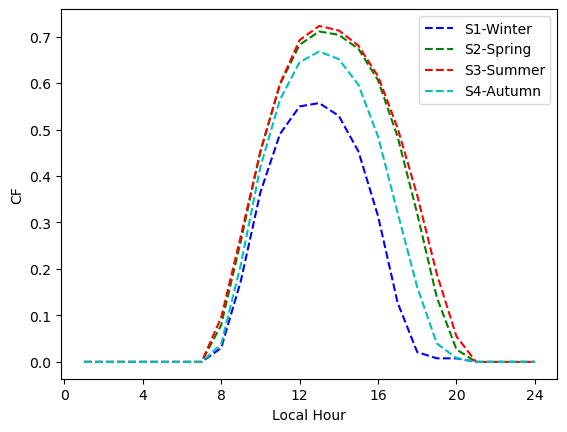

In [278]:
#Example
Tech="SOL_EIA930"
AvgY_CF=0.21 #CF from 2021 NC summary statistics
AverageGen=EIA930_CFs(Tech, AvgY_CF)
CFPlotEIA930(AverageGen)

### Solar

In [279]:
# For solar energy we donwload irradiation data from SAM model of NREL at the 3 centroid locations determined by the load (CentroidLoadR1,CentroidLoadR2,CentroidLoadR3)
# And define the distribution CF of the solar energy using irradiation ratios

#Read All Data On Region R1,R2,R3 for solar DNI-Direct Normal Irradiation
def GetAverageDNI_GHI(Region):
    SAMPaths = glob.glob(SAM_NREL_Path+"Sun/"+Region + "\*.csv")
    FileData=pd.DataFrame(columns=["Year","Season","Hour", "DNI","GHI"])

    for FilePath in SAMPaths:
        df = pd.read_csv(FilePath,skiprows=2,low_memory=False,usecols = ["Year","Month",'Hour', "DNI","GHI","Temperature"])
        
        SeasonDf=[]
        for month in df["Month"]:
            for j in range(len(Seasons)):
                if month in SeasonsMonthRange[j]:
                    SeasonDf.append(Seasons[j])
                    break

        FileData = pd.concat([FileData,pd.DataFrame({"Year":df["Year"],"Hour":df["Hour"],"DNI":df["DNI"],"Season":SeasonDf,"GHI":df["GHI"]})], ignore_index = True)
        #Hour 0 is 24:00 of the previous day, we change it to 24h of the current day (which is not fully correct but it is a good approximation given the data size and the averages we are going to take)
        #Improve it later
    FileData.loc[FileData["Hour"]==0,"Hour"]=24 

    AverageDNI_GHI=pd.DataFrame(columns=["Season","Hour", "DNI","GHI","RatioOfDNI","RatioOfGHI"])
    for Season in Seasons:
        for Hour in FileData["Hour"].unique():
            IdxIn=(FileData["Season"]==Season)*(FileData["Hour"]==Hour)
            df=FileData[IdxIn]
            DNIValue=df["DNI"].mean()#Mean of all years
            GHIValue=df["GHI"].mean()#Mean of all years
            AverageDNI_GHI=pd.concat([AverageDNI_GHI,pd.DataFrame([{"Season":Season,"Hour":Hour,"DNI":DNIValue, "GHI":GHIValue, "RatioOfDNI":-1,"RatioOfGHI":-1}])], ignore_index=True)

    #Expected sum total Irradiation in a year
    TIrr_DNI=0
    TIrr_GHI=0
    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24
        IdxIn=(AverageDNI_GHI["Season"]==Season)
        df=AverageDNI_GHI[IdxIn]
        TIrr_DNI+=df["DNI"].sum()*NumDaysSeason #Proxy for Total energy generation in a year
        TIrr_GHI+=df["GHI"].sum()*NumDaysSeason

    DistributionBySeason_DHI=[]
    DistributionBySeason_GHI=[]
    for Season in Seasons:
        NumDaysSeason=NumHoursSeason[Season]/24
        IdxIn=(AverageDNI_GHI["Season"]==Season)
        df=AverageDNI_GHI[IdxIn]

        RatioOfDNI=df["DNI"]/df["DNI"].sum()
        AverageDNI_GHI.loc[IdxIn,"RatioOfDNI"]=RatioOfDNI #For a specific season, what is the fraction of the total generation in the season that happens at each hour of the day (CSP)

        RatioOfGHI=df["GHI"]/df["GHI"].sum()
        AverageDNI_GHI.loc[IdxIn,"RatioOfGHI"]=RatioOfGHI #For a specific season, what is the fraction of the total generation in the season that happens at each hour of the day (PV)

        DistributionBySeason_DHI.append(df["DNI"].sum()*NumDaysSeason/TIrr_DNI)
        DistributionBySeason_GHI.append(df["GHI"].sum()*NumDaysSeason/TIrr_GHI)

    DistributionBySeason=pd.DataFrame({"Season":Seasons,"RatioOfDNI":DistributionBySeason_DHI,"RatioOfGHI":DistributionBySeason_GHI})

    return AverageDNI_GHI,DistributionBySeason

AverageDNI_GHI_R1, DistributionBySeason_R1 = GetAverageDNI_GHI("R1")
AverageDNI_GHI_R2, DistributionBySeason_R2 = GetAverageDNI_GHI("R2")
AverageDNI_GHI_R3, DistributionBySeason_R3 = GetAverageDNI_GHI("R3")


#### Plot Distribution of Solar Radiation

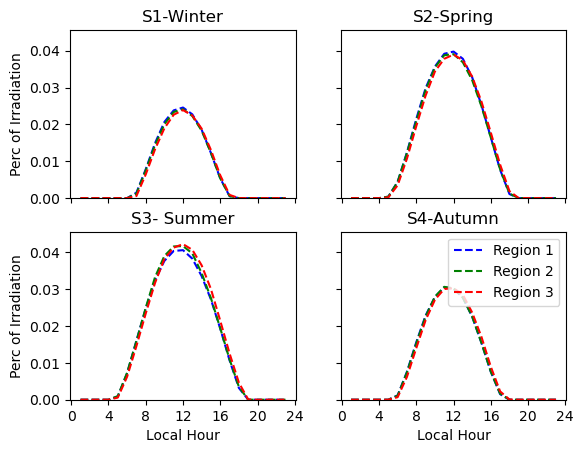

In [280]:
fig, axs = plt.subplots(2, 2)
R_S1Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S1"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S1"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S1"]]
R_S2Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S2"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S2"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S2"]]
R_S3Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S3"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S3"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S3"]]
R_S4Data=[AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S4"],AverageDNI_GHI_R2[AverageDNI_GHI_R2["Season"]=="S4"],AverageDNI_GHI_R3[AverageDNI_GHI_R3["Season"]=="S4"]]

R_S1=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S1"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S1"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S1"]]
R_S2=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S2"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S2"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S2"]]
R_S3=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S3"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S3"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S3"]]
R_S4=[DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S4"],DistributionBySeason_R2[DistributionBySeason_R2["Season"]=="S4"],DistributionBySeason_R3[DistributionBySeason_R3["Season"]=="S4"]]

R1_S3Data=AverageDNI_GHI_R1[AverageDNI_GHI_R1["Season"]=="S3"]
R1_S3=DistributionBySeason_R1[DistributionBySeason_R1["Season"]=="S3"]
x=R1_S3Data["Hour"].unique()

MinY=0
MaxY=0.005+(R1_S3Data["RatioOfGHI"]*R1_S3["RatioOfGHI"].values[0]).max()

axs[0, 0].set_title('S1-Winter')
axs[0, 1].set_title('S2-Spring')
axs[1, 0].set_title('S3- Summer')
axs[1, 1].set_title('S4-Autumn')

axs[0, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[0, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))



Colors=list(mcolors.BASE_COLORS.keys())
for i in range(3):
    axs[0, 0].plot(x[1:], R_S1Data[i]["RatioOfGHI"][1:]*R_S1[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))
    axs[0, 1].plot(x[1:], R_S2Data[i]["RatioOfGHI"][1:]*R_S2[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 0].plot(x[1:], R_S3Data[i]["RatioOfGHI"][1:]*R_S3[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 1].plot(x[1:], R_S4Data[i]["RatioOfGHI"][1:]*R_S4[i]["RatioOfGHI"].values[0],Colors[i]+"--",label="Region "+str(i+1))

axs[0, 0].set_ylim(MinY, MaxY)
axs[0, 1].set_ylim(MinY, MaxY)
axs[1, 0].set_ylim(MinY, MaxY)
axs[1, 1].set_ylim(MinY, MaxY)

for ax in axs.flat:
    ax.set(xlabel="Local Hour", ylabel='Perc of Irradiation')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend()

In [281]:
AverageGHI_Year_R1=AverageDNI_GHI_R1["GHI"].sum()/len(Seasons)/1000 #Kwh/m2/day
AverageGHI_Year_R2=AverageDNI_GHI_R2["GHI"].sum()/len(Seasons)/1000  #Kwh/m2/day
AverageGHI_Year_R3=AverageDNI_GHI_R3["GHI"].sum()/len(Seasons)/1000  #Kwh/m2/day

AverageDNI_Year_R1=AverageDNI_GHI_R1["DNI"].sum()/len(Seasons)/1000  #Kwh/m2/day
AverageDNI_Year_R2=AverageDNI_GHI_R2["DNI"].sum()/len(Seasons)/1000  #Kwh/m2/day
AverageDNI_Year_R3=AverageDNI_GHI_R3["DNI"].sum()/len(Seasons)/1000  #Kwh/m2/day

#NC was a GHI arond 4.5-4.75 which is Class 6 on the Utility-Scale/Commercial/Residential PV notation on NREL ATB-22
#NC was a DNI around 5 which is Class 12 on the Concentrating Solar Power notation on NREL ATB-22 - The CFs of this technology are not mapped on the ATB-22. Since it is a poor resource we did not map it on NC


#### Existing Solar Residential and Comercial

### Wind

In [282]:
#Get turbine data
#some supply curves: https://www.nrel.gov/gis/wind-supply-curves.html
def ReadTrubineData(NameDistribution):
    FilePath=SAM_NREL_Path+"Wind/Turbines.xlsx"
    df = pd.read_excel(FilePath,sheet_name=NameDistribution)
    HubHeight=df.iloc[0,0]
    Efficiency=df.iloc[0,1]
    WS_PowerCurve=df.iloc[:,4]
    CF_PowerCurve=df.iloc[:,5]
    WS_2_CF = lambda WS : np.interp(WS, WS_PowerCurve, CF_PowerCurve)*Efficiency

    return HubHeight,Efficiency,WS_2_CF

In [283]:
def CF_Wind(Region, NameDistribution):
#Read Excel with wind data

    if NameDistribution=="OFFSHORE":
        SAMPaths = glob.glob(SAM_NREL_Path+"Wind/Offshore" + "\*.csv")
    if NameDistribution=="LAND":
        SAMPaths = glob.glob(SAM_NREL_Path+"Wind/"+Region + "\*.csv")
        
    FileData=pd.DataFrame(columns=["Season","Hour", "CF"])
    HubHeight,Efficiency,WS_2_CF=ReadTrubineData(NameDistribution)

    for FilePath in SAMPaths:
        df = pd.read_csv(FilePath,skiprows=1,low_memory=False,usecols = ["Year","Month",'Hour', "wind speed at 100m (m/s)","wind speed at 120m (m/s)"])
        SeasonDf=[]
        for month in df["Month"]:
            for j in range(len(Seasons)):
                if month in SeasonsMonthRange[j]:
                    SeasonDf.append(Seasons[j])
                    break
                
        WS100=df["wind speed at 100m (m/s)"]
        WS120=df["wind speed at 120m (m/s)"]
        WindSpeedAdjusted = WS100 + (HubHeight-100)*(WS120-WS100)/(120-100) #Linear interpolation between 100m and 120m at the hub height
        WindSpeed110 = WS100 + (110-100)*(WS120-WS100)/(120-100) #Linear interpolation between 100m and 120m at the hub height
        CF=WS_2_CF(WindSpeedAdjusted)
        
        FileData = pd.concat([FileData,pd.DataFrame({"Hour":df["Hour"],"Season":SeasonDf,"CF":CF,"WS110":WindSpeed110})], ignore_index = True)

    #Hour 0 is 24:00 of the previous day, we change it to 24h of the current day (which is not fully correct but it is a good approximation given the data size and the averages we are going to take)
    #Improve it later
    FileData.loc[FileData["Hour"]==0,"Hour"]=24 
    WS_Statistics={"Mean":FileData["WS110"].mean(),
                   "Q75":FileData["WS110"].quantile(0.75),
                   "Q25":FileData["WS110"].quantile(0.25)}

    AverageCF=pd.DataFrame(columns=["Season","Hour", "CF"])
    for Season in Seasons:
        for Hour in FileData["Hour"].unique():
            IdxIn=(FileData["Season"]==Season)*(FileData["Hour"]==Hour)
            df=FileData[IdxIn]
            CF_AVG=df["CF"].mean()#Mean of all years

            AverageCF=pd.concat([AverageCF,pd.DataFrame([{"Hour":Hour,"Season":Season,"CF":CF_AVG}])], ignore_index=True)
            
    return AverageCF, WS_Statistics

AverageCF_R1,WS_Statistics_R1=CF_Wind("R1", "LAND")
AverageCF_R2,WS_Statistics_R2=CF_Wind("R2", "LAND")
AverageCF_R3,WS_Statistics_R3=CF_Wind("R3", "LAND")
AverageCF_Off,WS_Statistics_Off=CF_Wind("R3", "OFFSHORE")

#### Plot Distribution of Wind CF

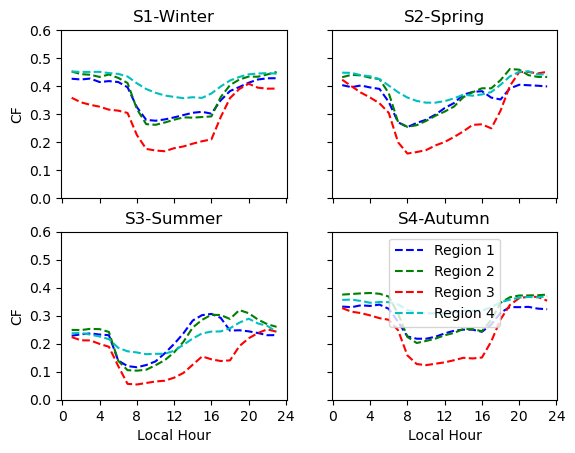

In [284]:
fig, axs = plt.subplots(2, 2)
R_S1Data=[AverageCF_R1[AverageCF_R1["Season"]=="S1"],AverageCF_R2[AverageCF_R2["Season"]=="S1"],AverageCF_R3[AverageCF_R3["Season"]=="S1"],AverageCF_Off[AverageCF_Off["Season"]=="S1"]]
R_S2Data=[AverageCF_R1[AverageCF_R1["Season"]=="S2"],AverageCF_R2[AverageCF_R2["Season"]=="S2"],AverageCF_R3[AverageCF_R3["Season"]=="S2"],AverageCF_Off[AverageCF_Off["Season"]=="S2"]]
R_S3Data=[AverageCF_R1[AverageCF_R1["Season"]=="S3"],AverageCF_R2[AverageCF_R2["Season"]=="S3"],AverageCF_R3[AverageCF_R3["Season"]=="S3"],AverageCF_Off[AverageCF_Off["Season"]=="S3"]]
R_S4Data=[AverageCF_R1[AverageCF_R1["Season"]=="S4"],AverageCF_R2[AverageCF_R2["Season"]=="S4"],AverageCF_R3[AverageCF_R3["Season"]=="S4"],AverageCF_Off[AverageCF_Off["Season"]=="S4"]]


x=AverageCF_Off["Hour"].unique()

MinY=0
MaxY=0.6

axs[0, 0].set_title('S1-Winter')
axs[0, 1].set_title('S2-Spring')
axs[1, 0].set_title('S3-Summer')
axs[1, 1].set_title('S4-Autumn')

axs[0, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[0, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 0].xaxis.set_ticks(np.arange(0, 24+1, 4))
axs[1, 1].xaxis.set_ticks(np.arange(0, 24+1, 4))



Colors=list(mcolors.BASE_COLORS.keys())
for i in range(4):
    axs[0, 0].plot(x[1:], R_S1Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))
    axs[0, 1].plot(x[1:], R_S2Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 0].plot(x[1:], R_S3Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))
    axs[1, 1].plot(x[1:], R_S4Data[i]["CF"][1:].values,Colors[i]+"--",label="Region "+str(i+1))

axs[0, 0].set_ylim(MinY, MaxY)
axs[0, 1].set_ylim(MinY, MaxY)
axs[1, 0].set_ylim(MinY, MaxY)
axs[1, 1].set_ylim(MinY, MaxY)

for ax in axs.flat:
    ax.set(xlabel="Local Hour", ylabel='CF')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend()

In [285]:
print("Average CF for R1: "+str(AverageCF_R1["CF"].mean()))
print("Average CF for R2: "+str(AverageCF_R2["CF"].mean()))
print("Average CF for R3: "+str(AverageCF_R3["CF"].mean()))
print("Average CF for Offshore: "+str(AverageCF_Off["CF"].mean()))

print("\n\nAverage WS for R1: %.2f \nQ75 WS for R1: %.2f \nQ25 WS for R1: %.2f"%(WS_Statistics_R1["Mean"],WS_Statistics_R1["Q75"],WS_Statistics_R1["Q25"]))
print("\n\nAverage WS for R2: %.2f \nQ75 WS for R2: %.2f \nQ25 WS for R2: %.2f"%(WS_Statistics_R2["Mean"],WS_Statistics_R2["Q75"],WS_Statistics_R2["Q25"]))
print("\n\nAverage WS for R3: %.2f \nQ75 WS for R3: %.2f \nQ25 WS for R3: %.2f"%(WS_Statistics_R3["Mean"],WS_Statistics_R3["Q75"],WS_Statistics_R3["Q25"]))
print("\n\nAverage WS for Offshore: %.2f \nQ75 WS for Offshore: %.2f \nQ25 WS for Offshore: %.2f"%(WS_Statistics_Off["Mean"],WS_Statistics_Off["Q75"],WS_Statistics_Off["Q25"]))


Average CF for R1: 0.30853005879759604
Average CF for R2: 0.3241554154135524
Average CF for R3: 0.25153295158986805
Average CF for Offshore: 0.34417338265121505


Average WS for R1: 7.06 
Q75 WS for R1: 9.05 
Q25 WS for R1: 4.88


Average WS for R2: 7.19 
Q75 WS for R2: 9.38 
Q25 WS for R2: 4.80


Average WS for R3: 6.26 
Q75 WS for R3: 8.61 
Q25 WS for R3: 3.67


Average WS for Offshore: 7.90 
Q75 WS for Offshore: 10.29 
Q25 WS for Offshore: 5.17


### Hydro

In [286]:
#The precipitation modulates the probability distribution of the CF. Which yearly values come from ORNL
def CF_Hydro(Region):
    HydroData_df = pd.read_excel(HydroDataPath,skiprows=1,sheet_name="Operational")
    HydroData_df=HydroData_df[HydroData_df["State"]==State] #Hydro Data for NC
    HydroData_df=HydroData_df[~(pd.isnull(HydroData_df["CH_MWh"]) + pd.isnull(HydroData_df["CH_MW"]))] #only use valid data

    AverageMWYear=HydroData_df["CH_MWh"].sum()/(365.25*24)#Average MW generated
    CF_Year=AverageMWYear/(HydroData_df["CH_MW"].sum())#Capacity Factor. all tech is on region 3

    HydroData_df = pd.read_excel(HydroDataPath,skiprows=1,sheet_name="Operational")
    df_Precipitation = pd.read_excel(SAM_NREL_Path+"Hydro_USGS/"+Region + "/USGS.xlsx")

    df_Precipitation["Month"]
    df_Precipitation["Precipitation [mm]"]

    AverageCF=pd.DataFrame(columns=["Season","Hour", "CF"])

    for j in range(len(Seasons)):
        Season=Seasons[j]
        TotalPrec=0
        for month in df_Precipitation["Month"]:
            if month in SeasonsMonthRange[j]:
                TotalPrec=TotalPrec+df_Precipitation[df_Precipitation["Month"]==month]["Precipitation [mm]"].values[0]
        RatioTotalPrec=TotalPrec/df_Precipitation["Precipitation [mm]"].sum()

        for Hour in range(len(TimeOfDay)):
            CF_AVG=CF_Year*RatioTotalPrec*365.25*24/NumHoursSeason[Season]
            
            AverageCF=pd.concat([AverageCF,pd.DataFrame([{"Hour":Hour+1,"Season":Season,"CF":CF_AVG}])], ignore_index=True)
    
    return AverageCF

AverageCF_R3=CF_Hydro("R3")
print(AverageCF_R3[AverageCF_R3["Hour"]==1])

   Season Hour        CF
0      S1    1  0.275664
24     S2    1  0.280388
48     S3    1  0.314894
72     S4    1  0.270291


### Write df on sql format

In [289]:
#Read Excel With Data on Yearly CF and technolgies we need to model on CapacityFactorProcess
Excel_CapacityFactorProcess = pd.read_excel(UserDataPath+"UserDataPart2.xlsx", sheet_name ='CapacityFactor')

#Only need to represent technologies at the user evolution level (Advanced, Moderate, Conservative)
Excel_CapacityFactorProcess=Excel_CapacityFactorProcess[(Excel_CapacityFactorProcess["Stage"]=="single")+(Excel_CapacityFactorProcess["Stage"]==UserScenario)]

CF_DistributionDict={"SOL":  GetAverageDNI_GHI,
                     "SOL_EIA930":  EIA930_CFs,
                     "WIND": CF_Wind,
                     "WATER": CF_Hydro}

TechWithSpecific_CFs=Excel_CapacityFactorProcess["tech"].unique()

In [290]:
#Return the CF_sql detaframe with the skeleton of the CFs for the technologies
# CapacityFactorProcess_sql=pd.DataFrame(columns=["regions","season_name","time_of_day_name","tech","vintage","cf_process","cf_process_notes"])
Data=[]
for tech in TechWithSpecific_CFs:
    df=Efficiency_sql[Efficiency_sql["tech"]==tech]
    Regions2Model=df["regions"]#regions we need to model for the technology
    vintages2model=df["vintage"]#vintages we need to model for the technology
    for region, vintage in zip(Regions2Model,vintages2model):
        for season in Seasons:
            for hour in TimeOfDay:
                Data.append([region,season,hour,tech,vintage,0,""])

CapacityFactorProcess_sql=pd.DataFrame(Data,columns=["regions","season_name","time_of_day_name","tech","vintage","cf_process","cf_process_notes"])

for tech in TechWithSpecific_CFs:

    TechStandardCfs=Excel_CapacityFactorProcess.loc[Excel_CapacityFactorProcess["tech"]==tech].iloc[:,6:]
    TechMinCF=TechStandardCfs.iloc[0,0]

    input_comm=Excel_CapacityFactorProcess.loc[Excel_CapacityFactorProcess["tech"]==tech,"input_comm"].values[0]
    NameDistribution=Excel_CapacityFactorProcess.loc[Excel_CapacityFactorProcess["tech"]==tech,"CF Distribution"].values[0]

    UniqueRegions=CapacityFactorProcess_sql[CapacityFactorProcess_sql["tech"]==tech]["regions"].unique()

    #Solar energy case
    if input_comm=="SOL":
        for region in UniqueRegions:       
            Distribution_S_H, Distribution_S = CF_DistributionDict[input_comm](region)
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()

            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)  & (CapacityFactorProcess_sql["vintage"]==vintage)\
                            & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])
                        
                        P_s=Distribution_S.loc[Distribution_S["Season"]==season,"RatioOf"+NameDistribution].values[0]
                        P_h_s=Distribution_S_H.loc[(Distribution_S_H["Season"]==season)*(Distribution_S_H["Hour"]==time+1), "RatioOf"+NameDistribution].values[0]

                        TechCF_Ratio=TechStandardCfs[max(vintage,TechStandardCfs.columns[0])].values[0]/TechMinCF
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=TechMinCF*365.25*24*P_s*P_h_s/(NumHoursSeason[season]/24)*TechCF_Ratio

    #Solar energy case
    if input_comm=="SOL_EIA930":
        Data_CF_SOL = CF_DistributionDict[input_comm](input_comm,1)
        for region in UniqueRegions:       
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()

            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region) & (CapacityFactorProcess_sql["vintage"]==vintage) \
                            & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])

                        CF=Data_CF_SOL.loc[(Data_CF_SOL["Season"]==season)*(Data_CF_SOL["Hour"]==time+1), "CF"].values[0] #Defined as a tech in 2020
                        
                        TechCF_Ratio=TechStandardCfs[max(vintage,TechStandardCfs.columns[0])].values[0]
                        CF=CF*TechCF_Ratio
                        if CF<0.005:
                            CF=0
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=CF
                        #The CF of each tech scales as define in the CF presented in the excel file

    #Wind energy case
    if input_comm=="WIND":
        for region in UniqueRegions:       
            Data_CF_Wind,_ = CF_DistributionDict[input_comm](region, NameDistribution)
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()

            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region) & (CapacityFactorProcess_sql["vintage"]==vintage) \
                            & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])
                        CF=Data_CF_Wind.loc[(Data_CF_Wind["Season"]==season)*(Data_CF_Wind["Hour"]==time+1), "CF"].values[0] #Defined as a tech in 2020
                        
                        
                        TechCF_Ratio=TechStandardCfs[max(vintage,TechStandardCfs.columns[0])].values[0]/TechMinCF
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=CF*TechCF_Ratio
                        #The CF of each tech scales as define in the CF presented in the excel file

    #Hydro energy case
    if input_comm=="WATER":
        for region in UniqueRegions:       
            Data_CF_Hydro=CF_DistributionDict[input_comm](region)
            UniqueVintages=CapacityFactorProcess_sql[(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region)]["vintage"].unique()
            for vintage in UniqueVintages:
                for season in Seasons:
                    for time in range(len(TimeOfDay)):
                        IdxIn=(CapacityFactorProcess_sql["tech"]==tech) & (CapacityFactorProcess_sql["regions"]==region) & (CapacityFactorProcess_sql["vintage"]==vintage)\
                             & (CapacityFactorProcess_sql["season_name"]==season) & (CapacityFactorProcess_sql["time_of_day_name"]==TimeOfDay[time])
                        CF=Data_CF_Hydro.loc[(Data_CF_Hydro["Season"]==season)*(Data_CF_Hydro["Hour"]==time+1), "CF"].values[0]
                        CapacityFactorProcess_sql.loc[IdxIn,"cf_process"]=CF #Capacity factor do no depend on the vintage
            

#### Verify CF consistency (values 0-1)


In [291]:
#Verify Data consistency
if np.sum(CapacityFactorProcess_sql["cf_process"]>=1)>0:
    print("ERROR: There are some CF values that are larger than one")
    print(CapacityFactorProcess_sql.loc[CapacityFactorProcess_sql["cf_process"]>=1,:])
    sys.exit()
#CapacityFactorProcess_sql.to_excel("Debug.xlsx")